In [4]:
!pip install arch
!pip install econml
!pip install tensorflow
!pip install keras

In [5]:
# CHUNK 1: LIBRARY IMPORTS & ENVIRONMENT SETUP

# Basic libraries
import pandas as pd      # Data handling
import numpy as np       # Numerical computing

# Financial data sources (Yahoo Finance, for ETFs, VIX, Brent)
import yfinance as yf

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Econometric & statistical modeling
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima.model import ARIMA

# Advanced ML/causal analysis (optional; install if not present)
# from econml.dml import CausalForestDML      # For Causal Forests (pip install econml)
# from arch import arch_model                 # For GARCH (pip install arch)

# Plotting preferences
plt.style.use('ggplot')
pd.set_option('display.max_columns', 100)

print("Libraries imported successfully and environment is set up.")


Libraries imported successfully and environment is set up.


In [9]:
# CHUNK 2: FULL DATA ACQUISITION & MERGE (ICLN, XLE, VIX, Brent, Carbon, S&P 500, 10Y Rate)

import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader.data as web

# 1. PARAMETERS
start_date = '2010-01-01'
end_date = '2024-12-31'
carbon_csv_path = '/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/Carbon Emissions Futures Historical Data (Daily)_14Yr.csv'

# 2. DOWNLOAD ETF, VIX, BRENT, S&P 500
tickers = {
    'ICLN': 'ICLN',          # iShares Global Clean Energy ETF
    'XLE': 'XLE',            # Energy Select Sector SPDR Fund
    'VIX': '^VIX',           # CBOE Volatility Index
    'Brent': 'BZ=F',         # Brent Crude Oil Futures
    'SP500': '^GSPC',        # S&P 500 Index
}

data = {}
for key, ticker in tickers.items():
    print(f"Downloading {key} ({ticker}) ...")
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    # Use Adj Close if available, else Close
    if 'Adj Close' in df.columns:
        df = df[['Adj Close']].rename(columns={'Adj Close': key})
    else:
        df = df[['Close']].rename(columns={'Close': key})
    data[key] = df

# 3. DOWNLOAD 10-YEAR TREASURY YIELD FROM FRED
print("Downloading 10Y Treasury yield from FRED ...")
dgs10 = web.DataReader('DGS10', 'fred', start_date, end_date)
dgs10 = dgs10.rename(columns={'DGS10': 'dgs10'})
data['dgs10'] = dgs10

# 4. MERGE ALL FINANCIAL SERIES ON DATE INDEX
df_etf = pd.concat(data.values(), axis=1)
df_etf = df_etf.dropna(how='all')
df_etf.index.name = 'date'

# FLATTEN ANY MULTIINDEX COLUMNS (for yfinance quirks)
if isinstance(df_etf.columns, pd.MultiIndex):
    df_etf.columns = ['_'.join([str(i) for i in col if str(i) != '']) for col in df_etf.columns.values]
df_etf.columns = [str(col) for col in df_etf.columns]

# 5. LOAD AND CLEAN CARBON PRICE DATA (from CSV)
df_carbon = pd.read_csv(carbon_csv_path)
df_carbon.columns = [col.strip().lower().replace(' ', '_') for col in df_carbon.columns]
df_carbon['date'] = pd.to_datetime(df_carbon['date'])
df_carbon = df_carbon.set_index('date')
df_carbon['price'] = df_carbon['price'].astype(str).str.replace(',', '').astype(float)
df_carbon = df_carbon.loc[(df_carbon.index >= df_etf.index.min()) & (df_carbon.index <= df_etf.index.max())]
df_carbon = df_carbon.rename(columns={'price': 'carbon_eua'})

# 6. MERGE CARBON PRICES INTO MAIN DATAFRAME
df_full = df_etf.join(df_carbon['carbon_eua'], how='left')
df_full['carbon_eua'] = df_full['carbon_eua'].fillna(method='ffill')

# 7. Forward fill macro series (especially dgs10, for weekends/holidays)
df_full['dgs10'] = df_full['dgs10'].fillna(method='ffill')

# 8. CHECK & SAVE
print("\nMerged DataFrame sample:")
print(df_full.head(10))
print("\nColumns in merged data:", df_full.columns.tolist())

df_full.to_csv('/Users/aditya/Desktop/MSQE PROJECT/Project_Data/financial_data_with_carbon_macro_2010_2024.csv')
print("\nAll data merged and saved as: financial_data_with_carbon_macro_2010_2024.csv")

# ------------------------------------------------------------
# END OF UPDATED CHUNK 2
# ------------------------------------------------------------



Merged DataFrame sample:
            ('ICLN', 'ICLN')  ('XLE', 'XLE')  ('VIX', '^VIX')  \
date                                                            
2010-01-04         16.418566       35.645321        20.040001   
2010-01-05         16.858027       35.936241        19.350000   
2010-01-06         17.002108       36.366589        19.160000   
2010-01-07         17.038134       36.312027        19.059999   
2010-01-08         17.189419       36.548412        18.129999   
2010-01-11         17.297489       36.499931        17.549999   
2010-01-12         16.778776       35.972622        18.250000   
2010-01-13         16.894045       36.105976        17.850000   
2010-01-14         16.440172       36.208996        17.629999   
2010-01-15         16.007917       35.918068        17.910000   

            ('Brent', 'BZ=F')  ('SP500', '^GSPC')  dgs10  carbon_eua  
date                                                                  
2010-01-04          80.120003         1132.989990  

/var/folders/1r/zy587f0538s953xzbmtbxc2h0000gn/T/ipykernel_57020/1712066725.py:60: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_full['carbon_eua'] = df_full['carbon_eua'].fillna(method='ffill')
/var/folders/1r/zy587f0538s953xzbmtbxc2h0000gn/T/ipykernel_57020/1712066725.py:63: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_full['dgs10'] = df_full['dgs10'].fillna(method='ffill')


Columns in dataframe: ["('ICLN', 'ICLN')", "('XLE', 'XLE')", "('VIX', '^VIX')", "('Brent', 'BZ=F')", "('SP500', '^GSPC')", 'dgs10', 'carbon_eua']
Detected columns: ICLN=('ICLN', 'ICLN'), XLE=('XLE', 'XLE'), Brent=('Brent', 'BZ=F'), Carbon=carbon_eua, SP500=('SP500', '^GSPC'), DGS10=dgs10
Added difference column for dgs10: dgs10_diff
Returns columns created: ["('ICLN', 'ICLN')_ret", "('XLE', 'XLE')_ret", "('Brent', 'BZ=F')_ret", 'carbon_eua_ret', "('SP500', '^GSPC')_ret"]


/var/folders/1r/zy587f0538s953xzbmtbxc2h0000gn/T/ipykernel_57020/2572765226.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


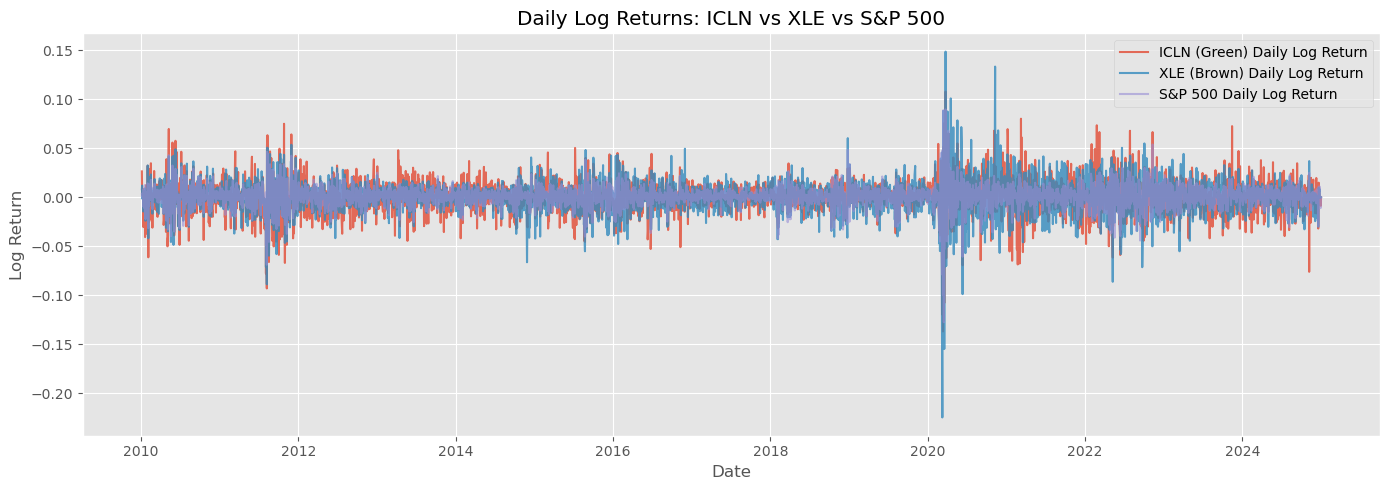


Saved cleaned/returns data as: financial_data_returns_2010_2024.csv


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the merged data
df = pd.read_csv('/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/financial_data_with_carbon_macro_2010_2024.csv', index_col=0, parse_dates=True)

print("Columns in dataframe:", df.columns.tolist())

# Robust auto-matching for asset columns
def find_col(substring, columns):
    for col in columns:
        if substring.lower() in col.lower():
            return col
    return None

ICLN_col = find_col('ICLN', df.columns)
XLE_col = find_col('XLE', df.columns)
Brent_col = find_col('Brent', df.columns)
carbon_col = find_col('carbon_eua', df.columns)
SP500_col = find_col('SP500', df.columns)
dgs10_col = find_col('dgs10', df.columns)

print(f"Detected columns: ICLN={ICLN_col}, XLE={XLE_col}, Brent={Brent_col}, Carbon={carbon_col}, SP500={SP500_col}, DGS10={dgs10_col}")

assets = [col for col in [ICLN_col, XLE_col, Brent_col, carbon_col, SP500_col] if col is not None]

# Forward-fill missing data
df = df.fillna(method='ffill')

# Calculate log returns for present assets (ICLN, XLE, Brent, Carbon, SP500)
returns_added = []
for col in assets:
    ret_col = f'{col}_ret'
    df[ret_col] = np.log(df[col] / df[col].shift(1))
    returns_added.append(ret_col)

# For the 10-year Treasury yield, you may want the level and/or daily change
if dgs10_col and f'{dgs10_col}_diff' not in df.columns:
    df[f'{dgs10_col}_diff'] = df[dgs10_col].diff()
    print(f"Added difference column for {dgs10_col}: {dgs10_col}_diff")

print("Returns columns created:", returns_added)

# Visualize ICLN and XLE returns if present
plt.figure(figsize=(14, 5))
if ICLN_col and f'{ICLN_col}_ret' in df.columns:
    plt.plot(df.index, df[f'{ICLN_col}_ret'], label='ICLN (Green) Daily Log Return', alpha=0.8)
if XLE_col and f'{XLE_col}_ret' in df.columns:
    plt.plot(df.index, df[f'{XLE_col}_ret'], label='XLE (Brown) Daily Log Return', alpha=0.8)
if SP500_col and f'{SP500_col}_ret' in df.columns:
    plt.plot(df.index, df[f'{SP500_col}_ret'], label='S&P 500 Daily Log Return', alpha=0.6)
plt.title('Daily Log Returns: ICLN vs XLE vs S&P 500')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.tight_layout()
plt.show()

# Save for future steps
df.to_csv('/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/financial_data_returns_2010_2024.csv')
print("\nSaved cleaned/returns data as: financial_data_returns_2010_2024.csv")


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Carbon shock threshold (1.5*std): 0.0456
Number of shock days detected: 357


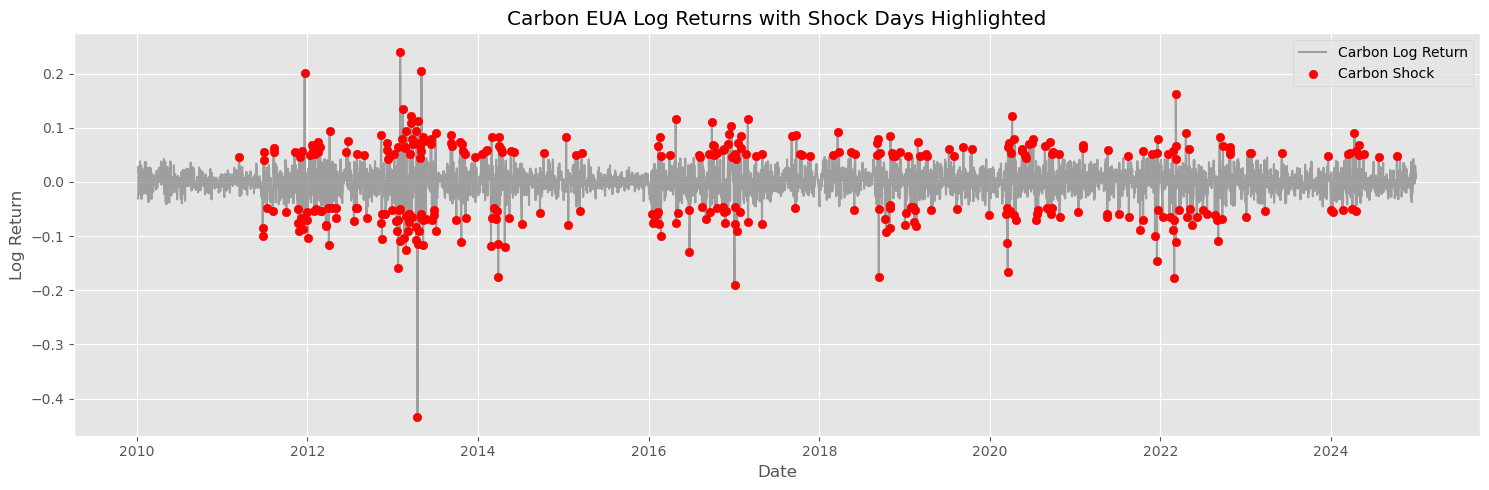

Saved file with carbon_shock column for regressions!


In [12]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# 1. Load your main file (with all assets/returns/macros)
df = pd.read_csv('/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/financial_data_returns_2010_2024.csv', index_col=0, parse_dates=True)

# 2. Detect carbon price and return columns (case-insensitive, robust)
def find_col(substring, columns):
    for col in columns:
        if substring.lower() in col.lower():
            return col
    return None

carbon_col = find_col('carbon_eua', df.columns)
carbon_ret_col = find_col('carbon_eua_ret', df.columns)

if not carbon_ret_col:
    # If not already in file, compute log return for carbon price
    if carbon_col:
        df['carbon_eua_ret'] = np.log(df[carbon_col] / df[carbon_col].shift(1))
        carbon_ret_col = 'carbon_eua_ret'
    else:
        raise Exception("Could not find a carbon price or return column.")

# 3. Fit AR(5) model to carbon log returns to get residuals
carbon_ret = df[carbon_ret_col].dropna()
model = ARIMA(carbon_ret, order=(5, 0, 0))
fit = model.fit()
resid = fit.resid

# 4. Assign residuals to DataFrame
df.loc[resid.index, 'carbon_shock_resid'] = resid

# 5. Flag carbon shocks: abs(resid) > 1.5 * std
shock_threshold = 1.5 * np.std(resid)
df['carbon_shock'] = (df['carbon_shock_resid'].abs() > shock_threshold).astype(int)

print(f"Carbon shock threshold (1.5*std): {shock_threshold:.4f}")
print(f"Number of shock days detected: {df['carbon_shock'].sum()}")

# 6. OPTIONAL: Visualize shocks
plt.figure(figsize=(15,5))
plt.plot(df.index, df[carbon_ret_col], label='Carbon Log Return', color='gray', alpha=0.7)
plt.scatter(df[df['carbon_shock'] == 1].index, df.loc[df['carbon_shock'] == 1, carbon_ret_col],
            color='red', label='Carbon Shock', zorder=10)
plt.title('Carbon EUA Log Returns with Shock Days Highlighted')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.tight_layout()
plt.show()

# 7. Save new file with shocks
df.to_csv('/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/financial_data_returns_2010_2024.csv')
print("Saved file with carbon_shock column for regressions!")

# ------------------------------------------------------------
# END OF CHUNK 4 (Carbon Shock Assignment)
# ------------------------------------------------------------


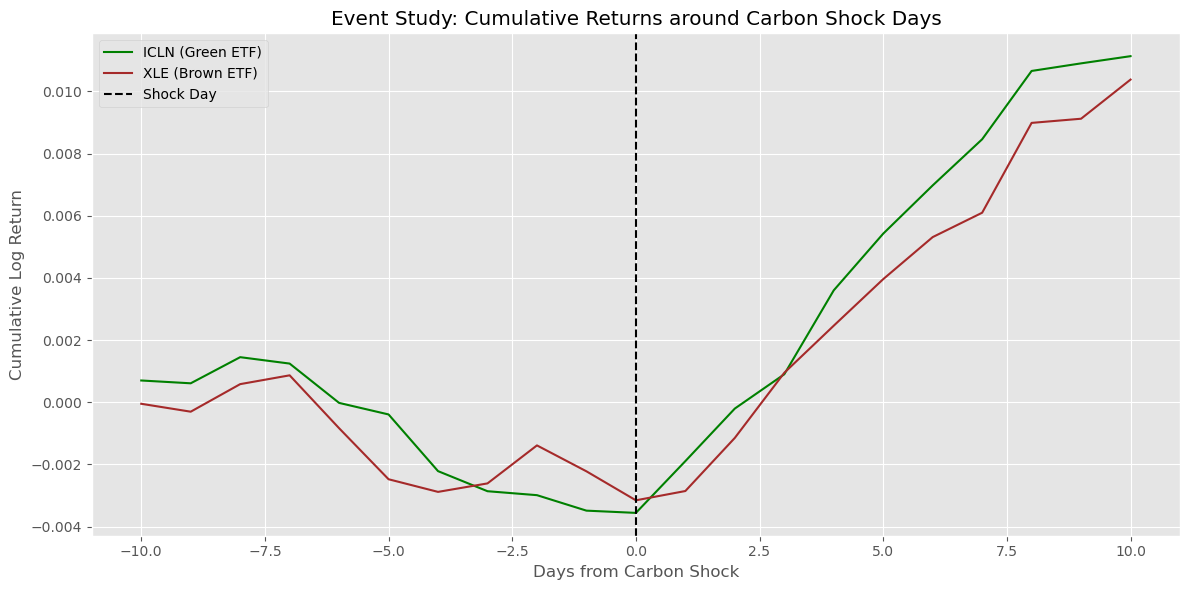


Average cumulative returns around shocks:
    days_from_shock  mean_cumret_icln  mean_cumret_xle
0               -10          0.000700        -0.000049
1                -9          0.000609        -0.000304
2                -8          0.001450         0.000583
3                -7          0.001244         0.000866
4                -6         -0.000021        -0.000835
5                -5         -0.000392        -0.002477
6                -4         -0.002216        -0.002883
7                -3         -0.002862        -0.002610
8                -2         -0.002989        -0.001388
9                -1         -0.003487        -0.002222
10                0         -0.003559        -0.003155
11                1         -0.001894        -0.002856
12                2         -0.000203        -0.001147
13                3          0.000900         0.000948
14                4          0.003600         0.002463
15                5          0.005423         0.003960
16                6   

In [13]:
# CHUNK 5: EVENT STUDY—ETF RETURNS BEFORE AND AFTER CARBON SHOCKS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data with carbon shocks
df = pd.read_csv('/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/financial_data_returns_shocks_2010_2024.csv', index_col=0, parse_dates=True)

# Helper to detect correct ETF columns
def find_col(substring, columns):
    for col in columns:
        if substring.lower() in col.lower():
            return col
    return None

# Find ETF return columns
icln_col = find_col('ICLN', df.columns)
xle_col = find_col('XLE', df.columns)
icln_ret_col = f'{icln_col}_ret'
xle_ret_col = f'{xle_col}_ret'

# Safety check
if icln_ret_col not in df.columns or xle_ret_col not in df.columns:
    raise ValueError("Could not find ICLN or XLE return columns.")

# Find shock event indices (skip first/last 10 days to allow for window)
shock_indices = df.index[df['carbon_shock'] == 1]
shock_indices = [idx for idx in shock_indices if (df.index.get_loc(idx) > 10) and (df.index.get_loc(idx) < len(df)-10)]

window = 10  # Days before/after shock
event_matrix_icln = []
event_matrix_xle = []

for event_date in shock_indices:
    loc = df.index.get_loc(event_date)
    window_slice = slice(loc-window, loc+window+1)
    event_matrix_icln.append(df.iloc[window_slice][icln_ret_col].values)
    event_matrix_xle.append(df.iloc[window_slice][xle_ret_col].values)

event_matrix_icln = np.array(event_matrix_icln)
event_matrix_xle = np.array(event_matrix_xle)
event_time = np.arange(-window, window+1)

# Calculate average (mean) cumulative returns over event windows
mean_icln = np.nanmean(np.cumsum(event_matrix_icln, axis=1), axis=0)
mean_xle = np.nanmean(np.cumsum(event_matrix_xle, axis=1), axis=0)

# Plot event study result
plt.figure(figsize=(12,6))
plt.plot(event_time, mean_icln, label='ICLN (Green ETF)', color='green')
plt.plot(event_time, mean_xle, label='XLE (Brown ETF)', color='brown')
plt.axvline(0, color='black', linestyle='--', label='Shock Day')
plt.title('Event Study: Cumulative Returns around Carbon Shock Days')
plt.xlabel('Days from Carbon Shock')
plt.ylabel('Cumulative Log Return')
plt.legend()
plt.tight_layout()
plt.show()

# Show as table as well
result_table = pd.DataFrame({
    'days_from_shock': event_time,
    'mean_cumret_icln': mean_icln,
    'mean_cumret_xle': mean_xle
})
print("\nAverage cumulative returns around shocks:")
print(result_table.head(2*window+1))

# Save table for reporting
result_table.to_csv('/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/event_study_cumulative_returns.csv', index=False)
print("\nSaved event study table as: event_study_cumulative_returns.csv")

# ------------------------------------------------------------
# END OF CHUNK 5
# ------------------------------------------------------------


In [14]:
import pandas as pd
import statsmodels.formula.api as smf
import re

# Load data
df = pd.read_csv('/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/financial_data_returns_2010_2024.csv', index_col=0, parse_dates=True)

# Helper: Safe clean and matching
def clean_col(col):
    # Lowercase, remove non-alphanumeric except underscores, strip repeated/leading/trailing underscores
    s = re.sub(r'[^0-9a-zA-Z_]+', '_', col).strip('_')
    s = re.sub(r'_+', '_', s)
    return s.lower()

df_clean = df.copy()
df_clean.columns = [clean_col(col) for col in df_clean.columns]
print("Cleaned columns:", list(df_clean.columns))

def find_col(substring, columns):
    substring = substring.lower().strip('_')
    for col in columns:
        if substring in col.strip('_').lower():
            return col
    return None

icln_ret_col = find_col('icln_ret', df_clean.columns)
xle_ret_col = find_col('xle_ret', df_clean.columns)
carbon_shock_col = find_col('carbon_shock', df_clean.columns)
vix_col = find_col('vix', df_clean.columns)
brent_col = find_col('brent', df_clean.columns)
sp500_ret_col = find_col('sp500_ret', df_clean.columns)
dgs10_col = find_col('dgs10', df_clean.columns)
dgs10_diff_col = find_col('dgs10_diff', df_clean.columns)

# Print detected
print("\nDetected columns:")
for varname, val in [
    ("icln_ret_col", icln_ret_col),
    ("xle_ret_col", xle_ret_col),
    ("carbon_shock_col", carbon_shock_col),
    ("vix_col", vix_col),
    ("brent_col", brent_col),
    ("sp500_ret_col", sp500_ret_col),
    ("dgs10_col", dgs10_col),
    ("dgs10_diff_col", dgs10_diff_col)
]:
    print(f"{varname}: {val}")

# Controls: Only use if numeric, not all NA or constant
controls = []
for col in [vix_col, brent_col, sp500_ret_col, dgs10_col]:
    if col and col in df_clean.columns:
        ser = df_clean[col]
        if pd.api.types.is_numeric_dtype(ser) and ser.notnull().sum() > 1 and ser.nunique(dropna=True) > 1:
            controls.append(col)
        else:
            print(f"Skipped control '{col}': Not numeric, too many NAs, or constant")

print("\nFinal controls used:", controls)

# --- Regression setup ---
regressions = []
if icln_ret_col and carbon_shock_col:
    formula_icln = f"{icln_ret_col} ~ {carbon_shock_col}" + (" + " + " + ".join(controls) if controls else "")
    needed_cols_icln = [icln_ret_col, carbon_shock_col] + controls
    regdata_icln = df_clean[needed_cols_icln].dropna()
    regressions.append(('ICLN', formula_icln, regdata_icln))
else:
    print("ICLN regression cannot run: missing required columns.")

if xle_ret_col and carbon_shock_col:
    formula_xle = f"{xle_ret_col} ~ {carbon_shock_col}" + (" + " + " + ".join(controls) if controls else "")
    needed_cols_xle = [xle_ret_col, carbon_shock_col] + controls
    regdata_xle = df_clean[needed_cols_xle].dropna()
    regressions.append(('XLE', formula_xle, regdata_xle))
else:
    print("XLE regression cannot run: missing required columns.")

# --- Run regressions ---
for label, formula, data in regressions:
    print(f"\n{label} Regression formula: {formula}")
    print(f"N rows used: {len(data)}")
    model = smf.ols(formula=formula, data=data).fit(cov_type='HC1')
    print(f"\n==== Regression Results: {label} ====\n")
    print(model.summary())
    with open(f"regression_results_{label.lower()}.txt", "w") as f:
        f.write(model.summary().as_text())
    print(f"\nRegression results saved as regression_results_{label.lower()}.txt.")

print("\nDone.")

# ------------------------------------------------------------
# END OF FULLY ROBUST CHUNK 6
# ------------------------------------------------------------


Cleaned columns: ['icln_icln', 'xle_xle', 'vix_vix', 'brent_bz_f', 'sp500_gspc', 'dgs10', 'carbon_eua', 'icln_icln_ret', 'xle_xle_ret', 'brent_bz_f_ret', 'carbon_eua_ret', 'sp500_gspc_ret', 'dgs10_diff', 'carbon_shock_resid', 'carbon_shock']

Detected columns:
icln_ret_col: icln_icln_ret
xle_ret_col: xle_xle_ret
carbon_shock_col: carbon_shock_resid
vix_col: vix_vix
brent_col: brent_bz_f
sp500_ret_col: None
dgs10_col: dgs10
dgs10_diff_col: dgs10_diff

Final controls used: ['vix_vix', 'brent_bz_f', 'dgs10']

ICLN Regression formula: icln_icln_ret ~ carbon_shock_resid + vix_vix + brent_bz_f + dgs10
N rows used: 3780

==== Regression Results: ICLN ====

                            OLS Regression Results                            
Dep. Variable:          icln_icln_ret   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     14.62
Date:                Tue, 

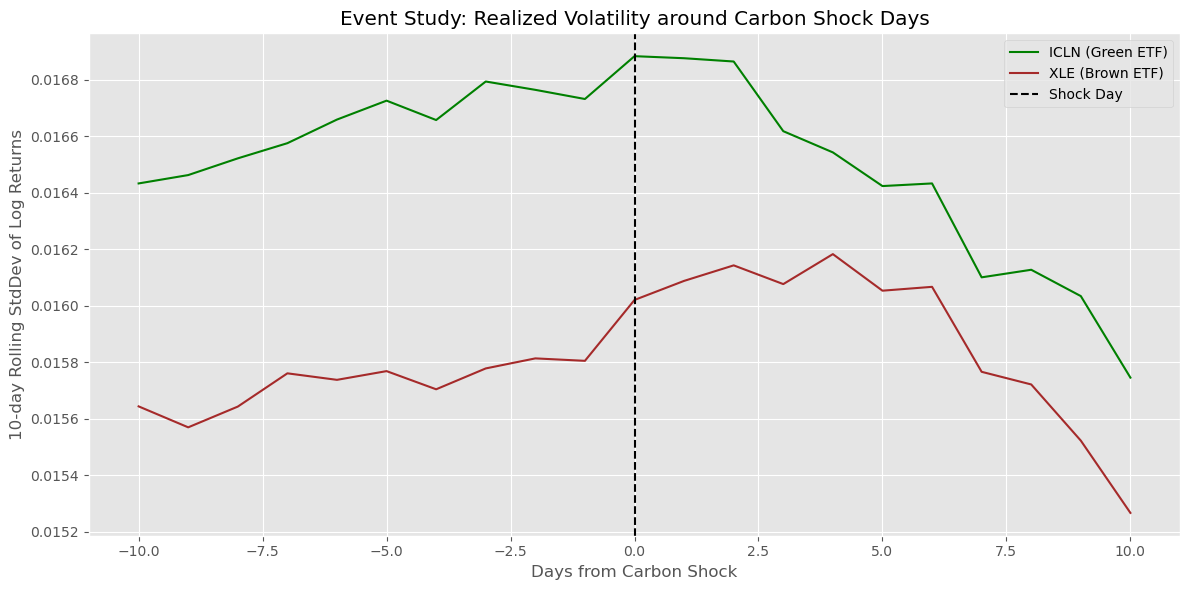


Saved ETF volatility event matrices as event_matrix_icln_vol.csv and event_matrix_xle_vol.csv.
Saved master dataframe with rolling volatility columns.


In [15]:
# CHUNK 7: EVENT STUDY—IMPACT OF CARBON SHOCKS ON ETF VOLATILITY

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/financial_data_returns_shocks_2010_2024.csv', index_col=0, parse_dates=True)

# Use the same robust detection of columns as before
def find_col(substring, columns):
    for col in columns:
        if substring.lower() in col.lower():
            return col
    return None

icln_col = find_col('ICLN', df.columns)
xle_col = find_col('XLE', df.columns)
icln_ret_col = f'{icln_col}_ret'
xle_ret_col = f'{xle_col}_ret'

# Compute 10-day rolling realized volatility for ICLN and XLE
vol_window = 10
df['icln_vol'] = df[icln_ret_col].rolling(window=vol_window).std()
df['xle_vol'] = df[xle_ret_col].rolling(window=vol_window).std()

# Identify shock dates (avoid edges)
shock_indices = df.index[df['carbon_shock'] == 1]
shock_indices = [idx for idx in shock_indices if (df.index.get_loc(idx) > 10) and (df.index.get_loc(idx) < len(df)-10)]

window = 10
event_matrix_icln_vol = []
event_matrix_xle_vol = []

for event_date in shock_indices:
    loc = df.index.get_loc(event_date)
    window_slice = slice(loc-window, loc+window+1)
    event_matrix_icln_vol.append(df.iloc[window_slice]['icln_vol'].values)
    event_matrix_xle_vol.append(df.iloc[window_slice]['xle_vol'].values)

event_matrix_icln_vol = np.array(event_matrix_icln_vol)
event_matrix_xle_vol = np.array(event_matrix_xle_vol)
event_time = np.arange(-window, window+1)

# Calculate average event window volatility
mean_icln_vol = np.nanmean(event_matrix_icln_vol, axis=0)
mean_xle_vol = np.nanmean(event_matrix_xle_vol, axis=0)

# Plot
plt.figure(figsize=(12,6))
plt.plot(event_time, mean_icln_vol, label='ICLN (Green ETF)', color='green')
plt.plot(event_time, mean_xle_vol, label='XLE (Brown ETF)', color='brown')
plt.axvline(0, color='black', linestyle='--', label='Shock Day')
plt.title('Event Study: Realized Volatility around Carbon Shock Days')
plt.xlabel('Days from Carbon Shock')
plt.ylabel('10-day Rolling StdDev of Log Returns')
plt.legend()
plt.tight_layout()
plt.show()

# Save full event matrix for robustness checks/reporting
event_window_cols = [f"t{d:+d}" for d in event_time]
event_df_icln_vol = pd.DataFrame(event_matrix_icln_vol, index=[df.index[df.index.get_loc(idx)] for idx in shock_indices], columns=event_window_cols)
event_df_xle_vol = pd.DataFrame(event_matrix_xle_vol, index=[df.index[df.index.get_loc(idx)] for idx in shock_indices], columns=event_window_cols)

event_df_icln_vol.to_csv('event_matrix_icln_vol.csv')
event_df_xle_vol.to_csv('event_matrix_xle_vol.csv')
print("\nSaved ETF volatility event matrices as event_matrix_icln_vol.csv and event_matrix_xle_vol.csv.")

# Save the main dataframe with vol columns for regression or advanced modeling
df.to_csv('/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/financial_data_returns_shocks_vol_2010_2024.csv')
print("Saved master dataframe with rolling volatility columns.")

# ------------------------------------------------------------
# END OF CHUNK 7
# ------------------------------------------------------------


In [16]:
import pandas as pd
import statsmodels.formula.api as smf
import re

# Load data (should already have rolling vol, carbon_shock, returns, macro)
df = pd.read_csv('/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/financial_data_returns_shocks_vol_2010_2024.csv', index_col=0, parse_dates=True)

def clean_col(col):
    s = re.sub(r'[^0-9a-zA-Z_]+', '_', col).strip('_')
    s = re.sub(r'_+', '_', s)
    return s.lower()

df_clean = df.copy()
df_clean.columns = [clean_col(col) for col in df_clean.columns]
print("Cleaned columns:", list(df_clean.columns))

def find_col(substring, columns):
    substring = substring.lower().strip('_')
    for col in columns:
        if substring in col.strip('_').lower():
            return col
    return None

# Key columns for both ETFs
icln_vol_col = find_col('icln_vol', df_clean.columns)
xle_vol_col  = find_col('xle_vol', df_clean.columns)
carbon_shock_col = find_col('carbon_shock', df_clean.columns)
vix_col = find_col('vix', df_clean.columns)
brent_col = find_col('brent', df_clean.columns)
sp500_ret_col = find_col('sp500_ret', df_clean.columns)
dgs10_col = find_col('dgs10', df_clean.columns)
dgs10_diff_col = find_col('dgs10_diff', df_clean.columns)

# Print detected
print("\nDetected columns:")
for varname, val in [
    ("icln_vol_col", icln_vol_col),
    ("xle_vol_col", xle_vol_col),
    ("carbon_shock_col", carbon_shock_col),
    ("vix_col", vix_col),
    ("brent_col", brent_col),
    ("sp500_ret_col", sp500_ret_col),
    ("dgs10_col", dgs10_col),
    ("dgs10_diff_col", dgs10_diff_col)
]:
    print(f"{varname}: {val}")

# Controls: Only use if numeric, not all NA or constant
controls = []
for col in [vix_col, brent_col, sp500_ret_col, dgs10_col]:
    if col and col in df_clean.columns:
        ser = df_clean[col]
        if pd.api.types.is_numeric_dtype(ser) and ser.notnull().sum() > 1 and ser.nunique(dropna=True) > 1:
            controls.append(col)
        else:
            print(f"Skipped control '{col}': Not numeric, too many NAs, or constant")

print("\nFinal controls used:", controls)

# --- Regression setup ---
regressions = []
if icln_vol_col and carbon_shock_col:
    formula_icln = f"{icln_vol_col} ~ {carbon_shock_col}" + (" + " + " + ".join(controls) if controls else "")
    needed_cols_icln = [icln_vol_col, carbon_shock_col] + controls
    regdata_icln = df_clean[needed_cols_icln].dropna()
    regressions.append(('ICLN_vol', formula_icln, regdata_icln))
else:
    print("ICLN volatility regression cannot run: missing required columns.")

if xle_vol_col and carbon_shock_col:
    formula_xle = f"{xle_vol_col} ~ {carbon_shock_col}" + (" + " + " + ".join(controls) if controls else "")
    needed_cols_xle = [xle_vol_col, carbon_shock_col] + controls
    regdata_xle = df_clean[needed_cols_xle].dropna()
    regressions.append(('XLE_vol', formula_xle, regdata_xle))
else:
    print("XLE volatility regression cannot run: missing required columns.")

# --- Run regressions ---
for label, formula, data in regressions:
    print(f"\n{label} Regression formula: {formula}")
    print(f"N rows used: {len(data)}")
    model = smf.ols(formula=formula, data=data).fit(cov_type='HC1')
    print(f"\n==== Regression Results: {label} ====\n")
    print(model.summary())
    with open(f"regression_results_{label.lower()}.txt", "w") as f:
        f.write(model.summary().as_text())
    print(f"\nRegression results saved as regression_results_{label.lower()}.txt.")

print("\nDone.")

# ------------------------------------------------------------
# END OF UPDATED CHUNK 8
# ------------------------------------------------------------


Cleaned columns: ['icln_icln', 'xle_xle', 'vix_vix', 'brent_bz_f', 'sp500_gspc', 'dgs10', 'carbon_eua', 'icln_icln_ret', 'xle_xle_ret', 'brent_bz_f_ret', 'carbon_eua_ret', 'sp500_gspc_ret', 'dgs10_diff', 'carbon_shock_resid', 'carbon_shock', 'icln_vol', 'xle_vol']

Detected columns:
icln_vol_col: icln_vol
xle_vol_col: xle_vol
carbon_shock_col: carbon_shock_resid
vix_col: vix_vix
brent_col: brent_bz_f
sp500_ret_col: None
dgs10_col: dgs10
dgs10_diff_col: dgs10_diff

Final controls used: ['vix_vix', 'brent_bz_f', 'dgs10']

ICLN_vol Regression formula: icln_vol ~ carbon_shock_resid + vix_vix + brent_bz_f + dgs10
N rows used: 3771

==== Regression Results: ICLN_vol ====

                            OLS Regression Results                            
Dep. Variable:               icln_vol   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     346.5
Date:    

Cleaned columns: ['icln_icln', 'xle_xle', 'vix_vix', 'brent_bz_f', 'sp500_gspc', 'dgs10', 'carbon_eua', 'icln_icln_ret', 'xle_xle_ret', 'brent_bz_f_ret', 'carbon_eua_ret', 'sp500_gspc_ret', 'dgs10_diff', 'carbon_shock_resid', 'carbon_shock', 'icln_vol', 'xle_vol']

Detected columns:
icln_ret_col: icln_icln_ret
xle_ret_col: xle_xle_ret
carbon_shock_col: carbon_shock_resid
Fitting GARCH(1,1) for ICLN...
                       Zero Mean - GARCH Model Results                        
Dep. Variable:          icln_icln_ret   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6958.37
Distribution:                  Normal   AIC:                           13922.7
Method:            Maximum Likelihood   BIC:                           13941.4
                                        No. Observations:                 3780
Date:                Tue, May 27 2025   Df

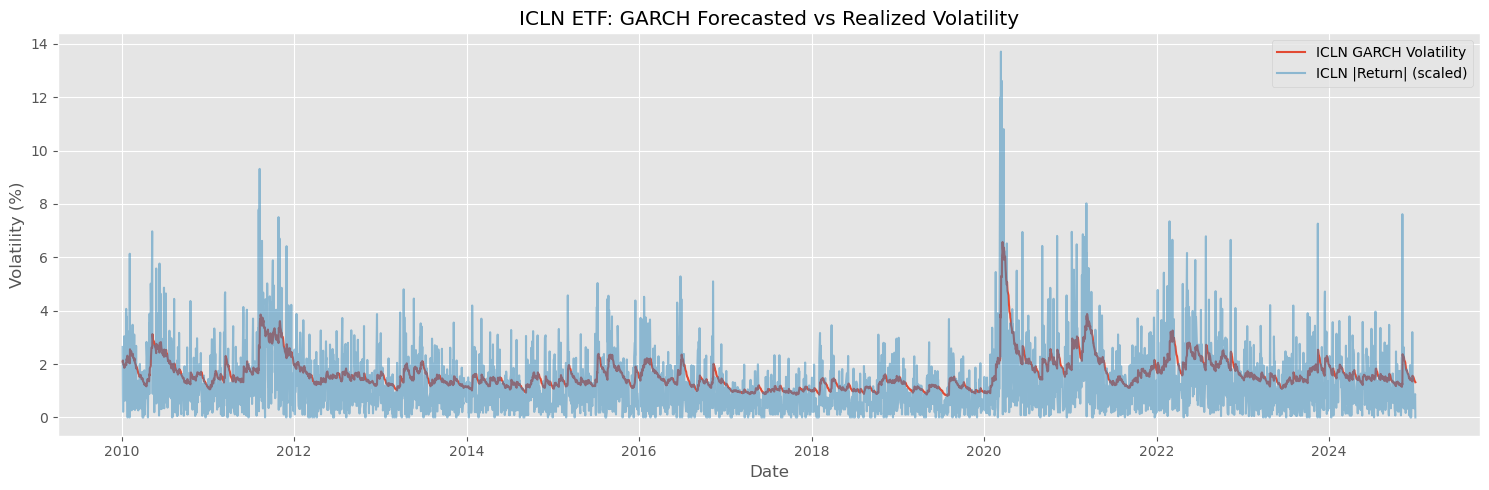

Fitting GARCH(1,1) for XLE...
                       Zero Mean - GARCH Model Results                        
Dep. Variable:            xle_xle_ret   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6703.97
Distribution:                  Normal   AIC:                           13413.9
Method:            Maximum Likelihood   BIC:                           13432.7
                                        No. Observations:                 3780
Date:                Tue, May 27 2025   Df Residuals:                     3780
Time:                        18:24:53   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0262  8.421

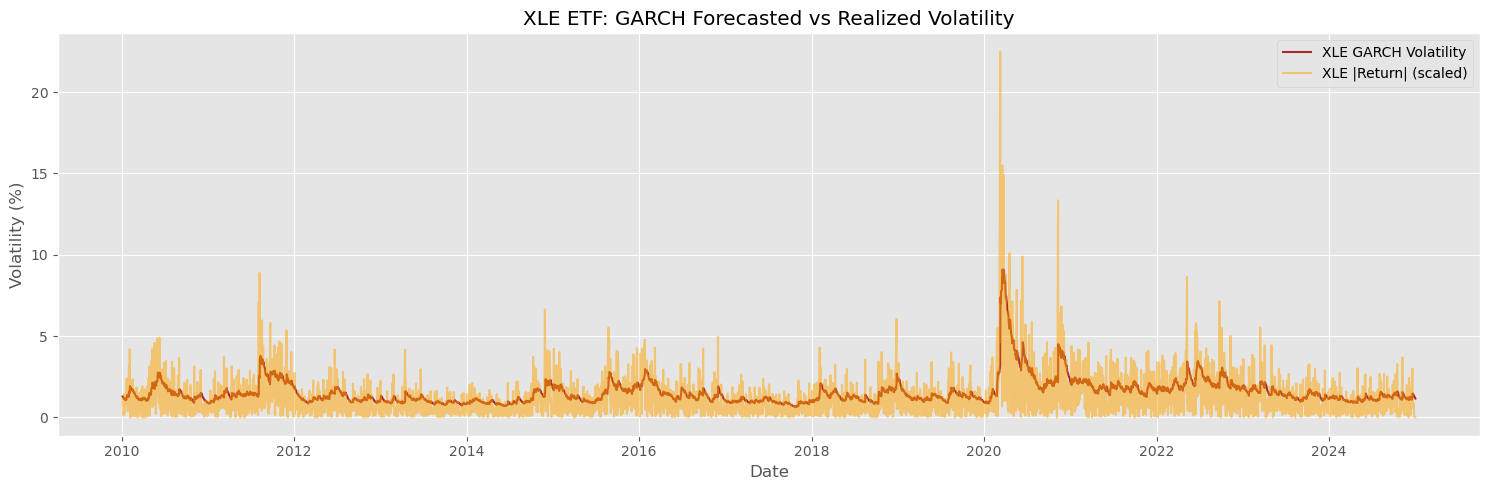


Saved GARCH results for both ICLN and XLE as financial_data_garch_2010_2024.csv


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import re

# Load your (already returns- and vol-augmented) dataset
df = pd.read_csv('/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/financial_data_returns_shocks_vol_2010_2024.csv', index_col=0, parse_dates=True)

def clean_col(col):
    s = re.sub(r'[^0-9a-zA-Z_]+', '_', col).strip('_')
    s = re.sub(r'_+', '_', s)
    return s.lower()

df.columns = [clean_col(col) for col in df.columns]
print("Cleaned columns:", list(df.columns))

def find_col(substring, columns):
    substring = substring.lower().strip('_')
    for col in columns:
        if substring in col.strip('_').lower():
            return col
    return None

icln_ret_col = find_col('icln_ret', df.columns)
xle_ret_col  = find_col('xle_ret', df.columns)
carbon_shock_col = find_col('carbon_shock', df.columns)

print("\nDetected columns:")
for name, val in [
    ('icln_ret_col', icln_ret_col), ('xle_ret_col', xle_ret_col), ('carbon_shock_col', carbon_shock_col)
]:
    print(f"{name}: {val}")

# ----- GARCH for ICLN (Green ETF) -----
if icln_ret_col:
    returns_icln = df[icln_ret_col].dropna() * 100  # scale for GARCH
    print("Fitting GARCH(1,1) for ICLN...")
    garch_icln = arch_model(returns_icln, vol='Garch', p=1, q=1, mean='Zero', rescale=False)
    garch_result_icln = garch_icln.fit(disp='off')
    print(garch_result_icln.summary())
    df.loc[returns_icln.index, 'icln_garch_vol'] = garch_result_icln.conditional_volatility

    plt.figure(figsize=(15,5))
    plt.plot(df.loc[returns_icln.index].index, df.loc[returns_icln.index, 'icln_garch_vol'], label='ICLN GARCH Volatility')
    plt.plot(df.loc[returns_icln.index].index, np.abs(returns_icln), label='ICLN |Return| (scaled)', alpha=0.5)
    plt.title('ICLN ETF: GARCH Forecasted vs Realized Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility (%)')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("ICLN return column not found—skipping GARCH for ICLN.")

# ----- GARCH for XLE (Brown ETF) -----
if xle_ret_col:
    returns_xle = df[xle_ret_col].dropna() * 100
    print("Fitting GARCH(1,1) for XLE...")
    garch_xle = arch_model(returns_xle, vol='Garch', p=1, q=1, mean='Zero', rescale=False)
    garch_result_xle = garch_xle.fit(disp='off')
    print(garch_result_xle.summary())
    df.loc[returns_xle.index, 'xle_garch_vol'] = garch_result_xle.conditional_volatility

    plt.figure(figsize=(15,5))
    plt.plot(df.loc[returns_xle.index].index, df.loc[returns_xle.index, 'xle_garch_vol'], label='XLE GARCH Volatility', color='brown')
    plt.plot(df.loc[returns_xle.index].index, np.abs(returns_xle), label='XLE |Return| (scaled)', alpha=0.5, color='orange')
    plt.title('XLE ETF: GARCH Forecasted vs Realized Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility (%)')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("XLE return column not found—skipping GARCH for XLE.")

# Save GARCH results for both ETFs
df.to_csv('/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/financial_data_garch_2010_2024.csv')
print("\nSaved GARCH results for both ICLN and XLE as financial_data_garch_2010_2024.csv")

# ------------------------------------------------------------
# END OF FULLY ROBUST CHUNK 9
# ------------------------------------------------------------



ICLN Out-of-sample forecast errors (last 20%):
GARCH:   RMSE = 0.3324, MAE = 0.2583
Rolling: RMSE = 0.2222, MAE = 0.1278

XLE Out-of-sample forecast errors (last 20%):
GARCH:   RMSE = 0.2895, MAE = 0.2183
Rolling: RMSE = 0.2016, MAE = 0.1215


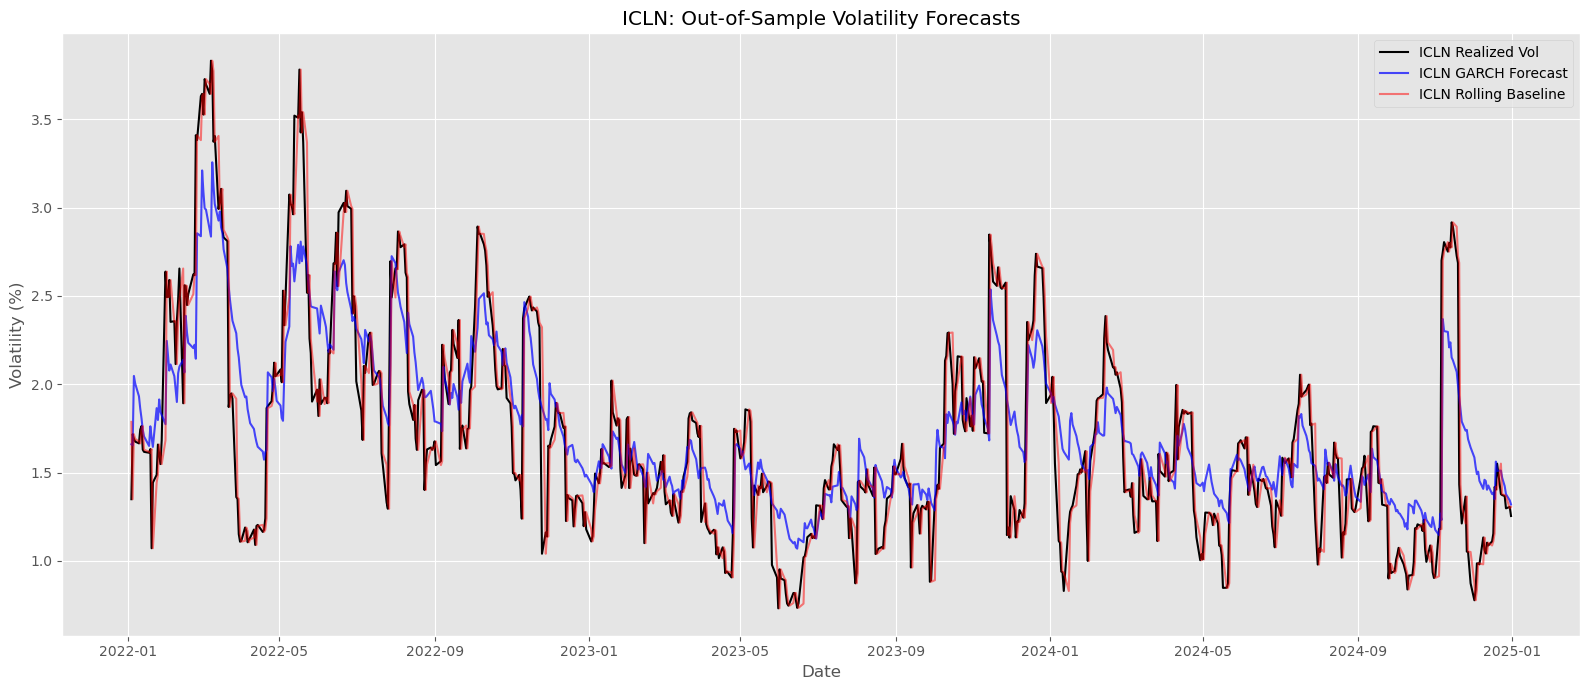

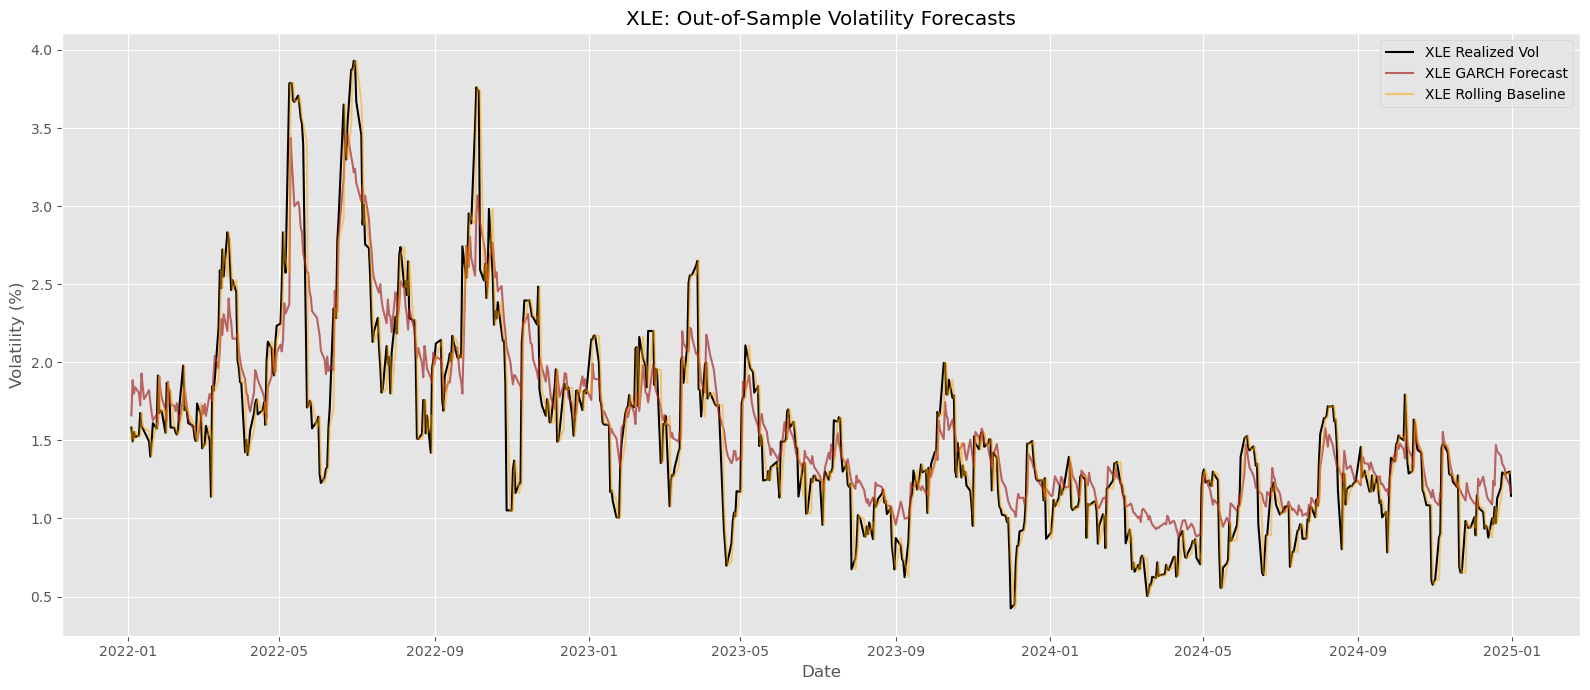


Saved comparison metrics as volatility_forecast_comparison_metrics.csv.


In [18]:
# CHUNK 10: VOLATILITY FORECAST COMPARISON FOR GREEN (ICLN) & BROWN (XLE) ETFS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the dataset with GARCH forecasts
df = pd.read_csv('/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/financial_data_garch_2010_2024.csv', index_col=0, parse_dates=True)

# Robustly find return and GARCH volatility columns
def find_col(substring, columns):
    for col in columns:
        if substring.lower() in col.lower():
            return col
    return None

icln_ret_col = find_col('ICLN_ret', df.columns)
xle_ret_col  = find_col('XLE_ret', df.columns)
icln_garch_vol_col = find_col('icln_garch_vol', df.columns)
xle_garch_vol_col  = find_col('xle_garch_vol', df.columns)

window = 10

# ---- Prepare realized and baseline volatility for both ETFs ----
df['icln_realized_vol'] = df[icln_ret_col].rolling(window=window).std() * 100
df['icln_baseline_vol'] = df['icln_realized_vol'].shift(1)

df['xle_realized_vol'] = df[xle_ret_col].rolling(window=window).std() * 100
df['xle_baseline_vol'] = df['xle_realized_vol'].shift(1)

# Drop rows with missing data for both ETFs
eval_icln = df[[icln_garch_vol_col, 'icln_baseline_vol', 'icln_realized_vol']].dropna()
eval_xle  = df[[xle_garch_vol_col,  'xle_baseline_vol',  'xle_realized_vol']].dropna()

# Use last 20% as test set
test_size_icln = int(len(eval_icln) * 0.2)
test_size_xle  = int(len(eval_xle)  * 0.2)
test_icln = eval_icln.iloc[-test_size_icln:]
test_xle  = eval_xle.iloc[-test_size_xle:]

# ---- ICLN: Calculate errors ----
rmse_garch_icln = np.sqrt(mean_squared_error(test_icln['icln_realized_vol'], test_icln[icln_garch_vol_col]))
mae_garch_icln  = mean_absolute_error(test_icln['icln_realized_vol'], test_icln[icln_garch_vol_col])

rmse_base_icln = np.sqrt(mean_squared_error(test_icln['icln_realized_vol'], test_icln['icln_baseline_vol']))
mae_base_icln  = mean_absolute_error(test_icln['icln_realized_vol'], test_icln['icln_baseline_vol'])

print("\nICLN Out-of-sample forecast errors (last 20%):")
print(f"GARCH:   RMSE = {rmse_garch_icln:.4f}, MAE = {mae_garch_icln:.4f}")
print(f"Rolling: RMSE = {rmse_base_icln:.4f}, MAE = {mae_base_icln:.4f}")

# ---- XLE: Calculate errors ----
rmse_garch_xle = np.sqrt(mean_squared_error(test_xle['xle_realized_vol'], test_xle[xle_garch_vol_col]))
mae_garch_xle  = mean_absolute_error(test_xle['xle_realized_vol'], test_xle[xle_garch_vol_col])

rmse_base_xle = np.sqrt(mean_squared_error(test_xle['xle_realized_vol'], test_xle['xle_baseline_vol']))
mae_base_xle  = mean_absolute_error(test_xle['xle_realized_vol'], test_xle['xle_baseline_vol'])

print("\nXLE Out-of-sample forecast errors (last 20%):")
print(f"GARCH:   RMSE = {rmse_garch_xle:.4f}, MAE = {mae_garch_xle:.4f}")
print(f"Rolling: RMSE = {rmse_base_xle:.4f}, MAE = {mae_base_xle:.4f}")

# ---- Plot ICLN forecasts ----
plt.figure(figsize=(16,7))
plt.plot(test_icln.index, test_icln['icln_realized_vol'], label='ICLN Realized Vol', color='black')
plt.plot(test_icln.index, test_icln[icln_garch_vol_col], label='ICLN GARCH Forecast', color='blue', alpha=0.7)
plt.plot(test_icln.index, test_icln['icln_baseline_vol'], label='ICLN Rolling Baseline', color='red', alpha=0.5)
plt.title('ICLN: Out-of-Sample Volatility Forecasts')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.tight_layout()
plt.show()

# ---- Plot XLE forecasts ----
plt.figure(figsize=(16,7))
plt.plot(test_xle.index, test_xle['xle_realized_vol'], label='XLE Realized Vol', color='black')
plt.plot(test_xle.index, test_xle[xle_garch_vol_col], label='XLE GARCH Forecast', color='brown', alpha=0.7)
plt.plot(test_xle.index, test_xle['xle_baseline_vol'], label='XLE Rolling Baseline', color='orange', alpha=0.5)
plt.title('XLE: Out-of-Sample Volatility Forecasts')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.tight_layout()
plt.show()

# ---- Save comparison metrics ----
metrics = pd.DataFrame({
    'ETF': ['ICLN', 'ICLN', 'XLE', 'XLE'],
    'Model': ['GARCH', 'Rolling Baseline', 'GARCH', 'Rolling Baseline'],
    'RMSE': [rmse_garch_icln, rmse_base_icln, rmse_garch_xle, rmse_base_xle],
    'MAE': [mae_garch_icln, mae_base_icln, mae_garch_xle, mae_base_xle]
})
metrics.to_csv('/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/volatility_forecast_comparison_metrics.csv', index=False)
print("\nSaved comparison metrics as volatility_forecast_comparison_metrics.csv.")

# ------------------------------------------------------------
# END OF CHUNK 10
# ------------------------------------------------------------


In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def leakage_check(df_ml, realized_vol_col, etf_label='ETF'):
    N_LAGS = 10
    features = []
    targets = []
    indices = []
    for i in range(N_LAGS, len(df_ml)):
        features.append(df_ml[realized_vol_col].iloc[i-N_LAGS:i].values)
        targets.append(df_ml[realized_vol_col].iloc[i])
        indices.append(df_ml.index[i])
    features = np.array(features)
    targets = np.array(targets).reshape(-1,1)
    indices = np.array(indices)
    split_idx = int(len(features)*0.8)
    train_idx = indices[:split_idx]
    test_idx = indices[split_idx:]

    # 1. Chronological split check
    assert (pd.Series(train_idx).max() < pd.Series(test_idx).min()), \
        f"Potential leakage in {etf_label}: train and test date ranges overlap!"
    print(f"\n{etf_label} Train date range: {train_idx[0]} to {train_idx[-1]}")
    print(f"{etf_label} Test date range: {test_idx[0]} to {test_idx[-1]}")

    # 2. Feature window check
    print(f"\nSample {etf_label} test set feature/target dates (should only use past values):")
    for i in range(3):
        ix = split_idx + i
        print(f"Sample {i+1}:")
        print("Feature window:", df_ml.index[ix-N_LAGS:ix].tolist())
        print("Target date  :", df_ml.index[ix])
        assert all(pd.Timestamp(d) < pd.Timestamp(df_ml.index[ix]) for d in df_ml.index[ix-N_LAGS:ix]), \
            f"Data leakage in {etf_label}: Feature window includes future values!"

    # 3. Scaling check
    scaler_X = MinMaxScaler()
    X_train = scaler_X.fit_transform(features[:split_idx])
    X_test  = scaler_X.transform(features[split_idx:])
    scaler_y = MinMaxScaler()
    y_train = scaler_y.fit_transform(targets[:split_idx])
    y_test  = scaler_y.transform(targets[split_idx:])
    print(f"\n{etf_label} scaling performed: Fit only on train set (leakage-safe)")

    # 4. Shuffle check
    assert np.all(np.diff(train_idx) > pd.Timedelta(0)), f"{etf_label} data shuffled—should not be!"
    print(f"\n{etf_label} data leakage diagnostics complete: No leakage detected in this pipeline!\n")


# === Run for ICLN ===
df_icln = pd.read_csv('/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/financial_data_garch_2010_2024.csv', index_col=0, parse_dates=True)
icln_ret_col = [col for col in df_icln.columns if 'icln_ret' in col.lower()][0]
# Realized vol already computed in your pipeline, or add here:
window = 10
df_icln['icln_realized_vol'] = df_icln[icln_ret_col].rolling(window=window).std() * 100
garch_vol_col = [col for col in df_icln.columns if 'icln_garch_vol' in col.lower()][0]
df_ml_icln = df_icln[['icln_realized_vol', garch_vol_col]].dropna().copy()

leakage_check(df_ml_icln, 'icln_realized_vol', etf_label='ICLN')


# === Run for XLE ===
df_xle = pd.read_csv('/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/financial_data_garch_2010_2024.csv', index_col=0, parse_dates=True)
xle_ret_col = [col for col in df_xle.columns if 'xle_ret' in col.lower()][0]
df_xle['xle_realized_vol'] = df_xle[xle_ret_col].rolling(window=window).std() * 100
garch_vol_col = [col for col in df_xle.columns if 'xle_garch_vol' in col.lower()][0]
df_ml_xle = df_xle[['xle_realized_vol', garch_vol_col]].dropna().copy()

leakage_check(df_ml_xle, 'xle_realized_vol', etf_label='XLE')



ICLN Train date range: 2010-02-02 00:00:00 to 2022-01-04 00:00:00
ICLN Test date range: 2022-01-05 00:00:00 to 2024-12-31 00:00:00

Sample ICLN test set feature/target dates (should only use past values):
Sample 1:
Feature window: [Timestamp('2021-12-07 00:00:00'), Timestamp('2021-12-08 00:00:00'), Timestamp('2021-12-09 00:00:00'), Timestamp('2021-12-10 00:00:00'), Timestamp('2021-12-13 00:00:00'), Timestamp('2021-12-14 00:00:00'), Timestamp('2021-12-15 00:00:00'), Timestamp('2021-12-16 00:00:00'), Timestamp('2021-12-17 00:00:00'), Timestamp('2021-12-20 00:00:00')]
Target date  : 2021-12-21 00:00:00
Sample 2:
Feature window: [Timestamp('2021-12-08 00:00:00'), Timestamp('2021-12-09 00:00:00'), Timestamp('2021-12-10 00:00:00'), Timestamp('2021-12-13 00:00:00'), Timestamp('2021-12-14 00:00:00'), Timestamp('2021-12-15 00:00:00'), Timestamp('2021-12-16 00:00:00'), Timestamp('2021-12-17 00:00:00'), Timestamp('2021-12-20 00:00:00'), Timestamp('2021-12-21 00:00:00')]
Target date  : 2021-12-22

2025-05-27 18:28:03.174950: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Training LSTM model for ICLN volatility forecasting...
Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0046
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0017
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0010
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.2119e-04
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.0549e-04
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.8403e-04
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3266e-04
Epoch 9/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.6147e-04
Epoch 10/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8835e-04
Epoch 11/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.8209e-04
Epoch 12/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2815e-04
Epoch 13/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.6382e-04
Epoch 14/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.3083e-04
Epoch 15/100
18

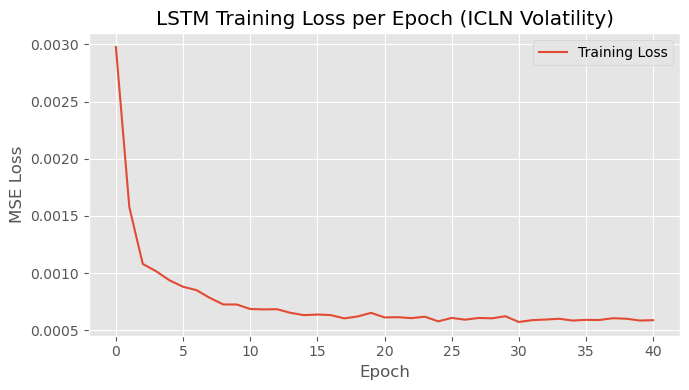

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

ICLN LSTM out-of-sample errors:
LSTM:  RMSE = 0.2224, MAE = 0.1352
GARCH: RMSE = 0.3324, MAE = 0.2582


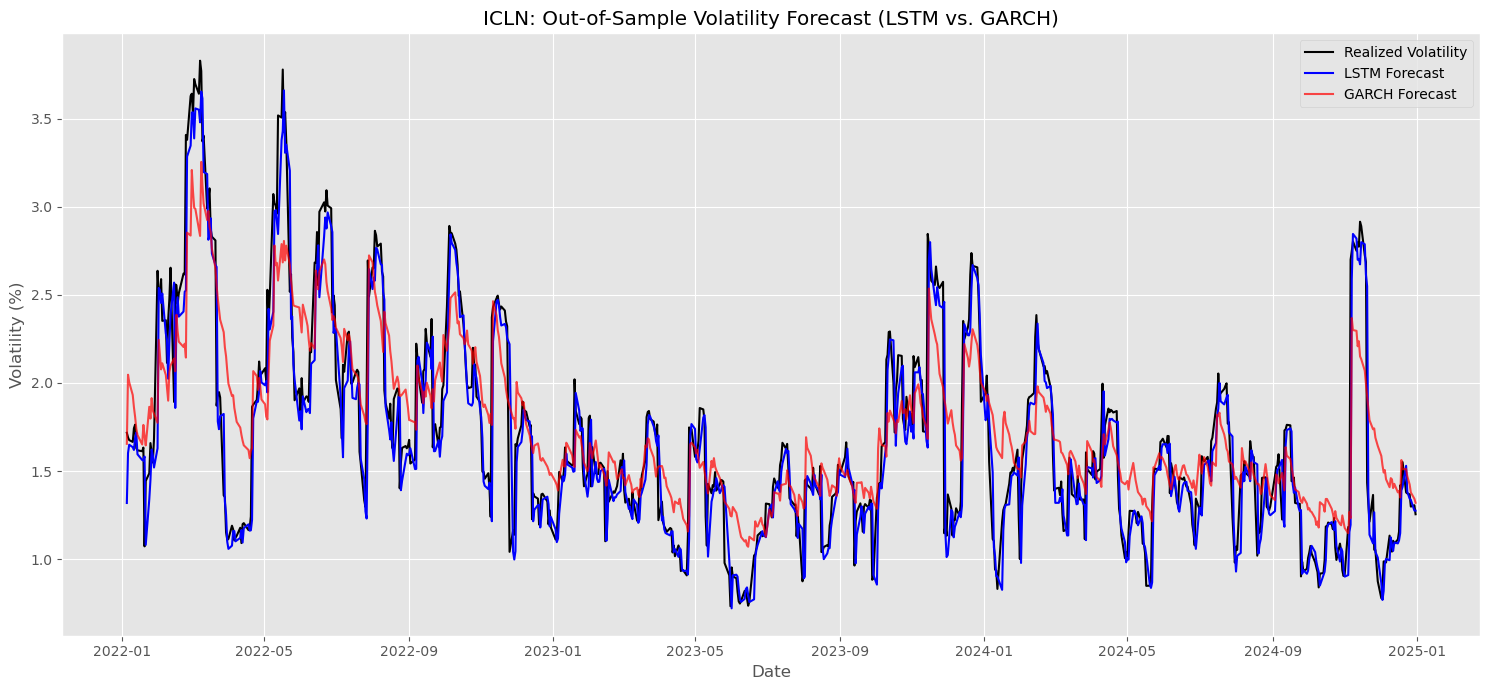


Saved ICLN LSTM vs GARCH results as icln_volatility_forecast_lstm_vs_garch.csv


In [20]:
# CHUNK 11: LSTM VOLATILITY FORECASTING WITH LOSS PLOTTING & EARLY STOPPING

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load dataset
df = pd.read_csv('/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/financial_data_garch_2010_2024.csv', index_col=0, parse_dates=True)

# Robust column finding
def find_col(substring, columns):
    for col in columns:
        if substring.lower() in col.lower():
            return col
    return None

icln_ret_col = find_col('ICLN_ret', df.columns)
garch_vol_col = find_col('icln_garch_vol', df.columns)

# Prepare volatility target (realized 10-day rolling std, scaled to %)
window = 10
df['icln_realized_vol'] = df[icln_ret_col].rolling(window=window).std() * 100

# Drop NA for modeling
df_ml = df[['icln_realized_vol', garch_vol_col]].dropna().copy()

# Prepare lagged features for time series (past N lags to predict next volatility)
N_LAGS = 10
features = []
targets = []

for i in range(N_LAGS, len(df_ml)):
    features.append(df_ml['icln_realized_vol'].iloc[i-N_LAGS:i].values)
    targets.append(df_ml['icln_realized_vol'].iloc[i])

features = np.array(features)
targets = np.array(targets).reshape(-1,1)

# Scale features & targets
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
features_scaled = scaler_X.fit_transform(features)
targets_scaled = scaler_y.fit_transform(targets)

# Split into train/test
split_idx = int(len(features_scaled)*0.8)
X_train, X_test = features_scaled[:split_idx], features_scaled[split_idx:]
y_train, y_test = targets_scaled[:split_idx], targets_scaled[split_idx:]

# LSTM expects [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], N_LAGS, 1))
X_test  = X_test.reshape((X_test.shape[0], N_LAGS, 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(32, input_shape=(N_LAGS, 1), return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Set up early stopping
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train model for up to 100 epochs, with early stopping
print("Training LSTM model for ICLN volatility forecasting...")
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=16, 
    verbose=1,
    callbacks=[early_stop]
)

# Plot the training loss curve
plt.figure(figsize=(7,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('LSTM Training Loss per Epoch (ICLN Volatility)')
plt.legend()
plt.tight_layout()
plt.show()

# Forecast
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)

# Match dates
test_dates = df_ml.index[N_LAGS+split_idx:]

# GARCH for same dates
garch_for_test = df_ml[garch_vol_col].iloc[N_LAGS+split_idx:].values

# Compute errors
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred))
mae_lstm  = mean_absolute_error(y_test_inv, y_pred)
rmse_garch = np.sqrt(mean_squared_error(y_test_inv, garch_for_test))
mae_garch  = mean_absolute_error(y_test_inv, garch_for_test)

print("\nICLN LSTM out-of-sample errors:")
print(f"LSTM:  RMSE = {rmse_lstm:.4f}, MAE = {mae_lstm:.4f}")
print(f"GARCH: RMSE = {rmse_garch:.4f}, MAE = {mae_garch:.4f}")

# Plot forecast results
plt.figure(figsize=(15,7))
plt.plot(test_dates, y_test_inv, label='Realized Volatility', color='black')
plt.plot(test_dates, y_pred, label='LSTM Forecast', color='blue')
plt.plot(test_dates, garch_for_test, label='GARCH Forecast', color='red', alpha=0.7)
plt.title('ICLN: Out-of-Sample Volatility Forecast (LSTM vs. GARCH)')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.tight_layout()
plt.show()

# Save outputs for report
results = pd.DataFrame({
    'date': test_dates,
    'realized_vol': y_test_inv.flatten(),
    'lstm_forecast': y_pred.flatten(),
    'garch_forecast': garch_for_test.flatten()
}).set_index('date')
results.to_csv('/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/icln_volatility_forecast_lstm_vs_garch.csv')
print("\nSaved ICLN LSTM vs GARCH results as icln_volatility_forecast_lstm_vs_garch.csv")

# ------------------------------------------------------------
# END OF CHUNK 11 (UPDATED)
# ------------------------------------------------------------


Training LSTM model for XLE volatility forecasting...
Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0039
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0014
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0010
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.5426e-04
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.0225e-04
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.3556e-04
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.9563e-04
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.6396e-04
Epoch 9/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.7786e-04
Epoch 10/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2438e-04
Epoch 11/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5617e-04
Epoch 12/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.1166e-04
Epoch 13/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1625e-04
Epoch 14/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9751e-04
Epoch 15/10

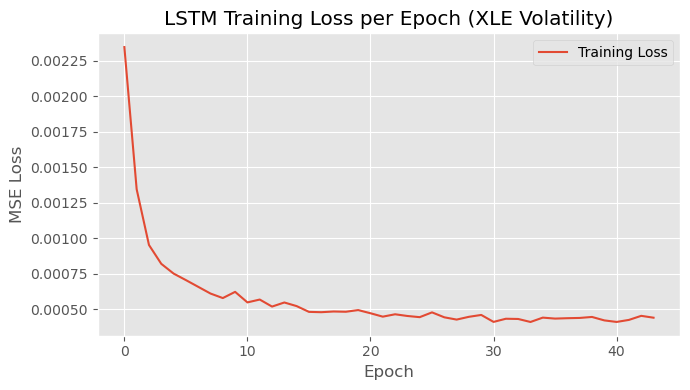

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

XLE LSTM out-of-sample errors:
LSTM:  RMSE = 0.2000, MAE = 0.1277
GARCH: RMSE = 0.2897, MAE = 0.2185


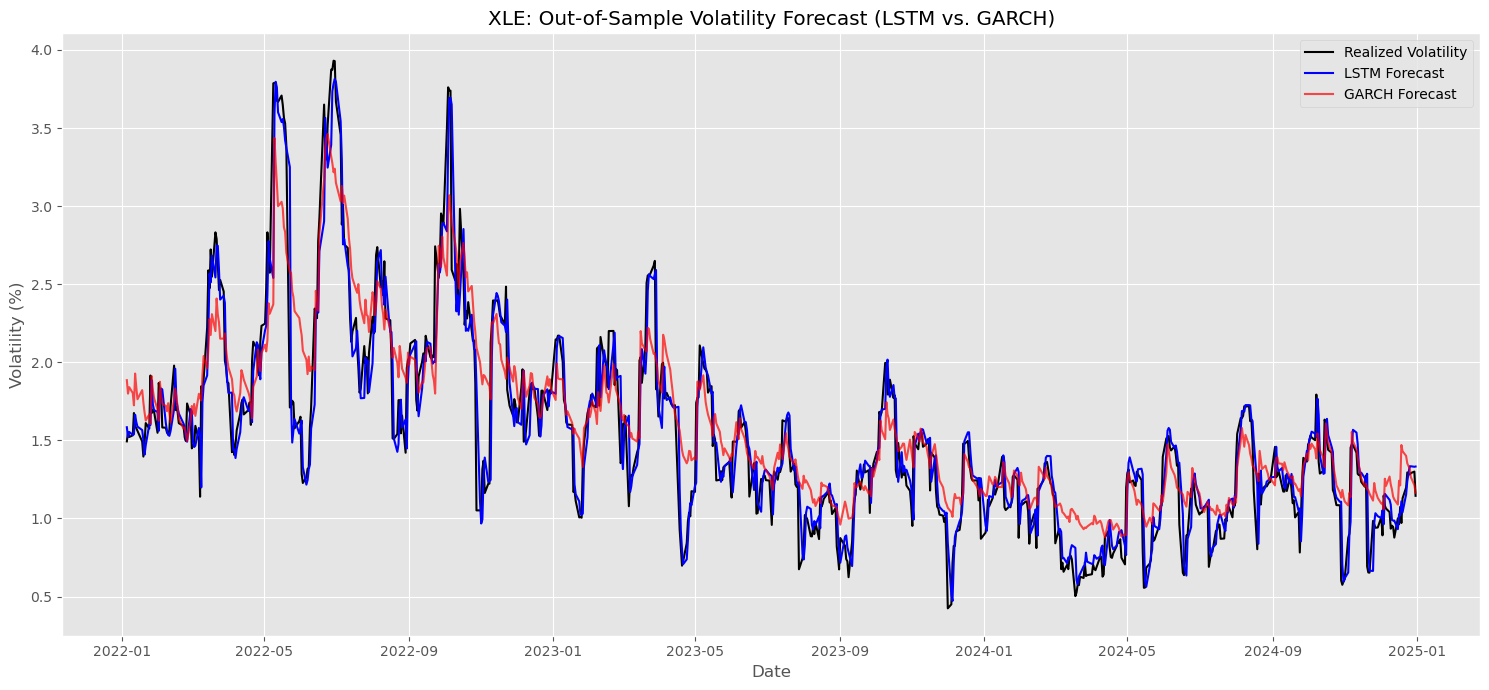


Saved XLE LSTM vs GARCH results as xle_volatility_forecast_lstm_vs_garch.csv


In [21]:
# CHUNK 11B: LSTM VOLATILITY FORECASTING FOR XLE (with Epoch Plot & Early Stopping)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load dataset
df = pd.read_csv('/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/financial_data_garch_2010_2024.csv', index_col=0, parse_dates=True)

# Robust column finding
def find_col(substring, columns):
    for col in columns:
        if substring.lower() in col.lower():
            return col
    return None

xle_ret_col = find_col('XLE_ret', df.columns)
garch_vol_col = find_col('xle_garch_vol', df.columns)

# Prepare volatility target (realized 10-day rolling std, scaled to %)
window = 10
df['xle_realized_vol'] = df[xle_ret_col].rolling(window=window).std() * 100

# Drop NA for modeling
df_ml = df[['xle_realized_vol', garch_vol_col]].dropna().copy()

# Prepare lagged features for time series (past N lags to predict next volatility)
N_LAGS = 10
features = []
targets = []

for i in range(N_LAGS, len(df_ml)):
    features.append(df_ml['xle_realized_vol'].iloc[i-N_LAGS:i].values)
    targets.append(df_ml['xle_realized_vol'].iloc[i])

features = np.array(features)
targets = np.array(targets).reshape(-1,1)

# Scale features & targets
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
features_scaled = scaler_X.fit_transform(features)
targets_scaled = scaler_y.fit_transform(targets)

# Split into train/test
split_idx = int(len(features_scaled)*0.8)
X_train, X_test = features_scaled[:split_idx], features_scaled[split_idx:]
y_train, y_test = targets_scaled[:split_idx], targets_scaled[split_idx:]

# LSTM expects [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], N_LAGS, 1))
X_test  = X_test.reshape((X_test.shape[0], N_LAGS, 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(32, input_shape=(N_LAGS, 1), return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Set up early stopping
early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train model for up to 100 epochs, with early stopping
print("Training LSTM model for XLE volatility forecasting...")
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=16, 
    verbose=1,
    callbacks=[early_stop]
)

# Plot the training loss curve
plt.figure(figsize=(7,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('LSTM Training Loss per Epoch (XLE Volatility)')
plt.legend()
plt.tight_layout()
plt.show()

# Forecast
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test)

# Match dates
test_dates = df_ml.index[N_LAGS+split_idx:]

# GARCH for same dates
garch_for_test = df_ml[garch_vol_col].iloc[N_LAGS+split_idx:].values

# Compute errors
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred))
mae_lstm  = mean_absolute_error(y_test_inv, y_pred)
rmse_garch = np.sqrt(mean_squared_error(y_test_inv, garch_for_test))
mae_garch  = mean_absolute_error(y_test_inv, garch_for_test)

print("\nXLE LSTM out-of-sample errors:")
print(f"LSTM:  RMSE = {rmse_lstm:.4f}, MAE = {mae_lstm:.4f}")
print(f"GARCH: RMSE = {rmse_garch:.4f}, MAE = {mae_garch:.4f}")

# Plot forecast results
plt.figure(figsize=(15,7))
plt.plot(test_dates, y_test_inv, label='Realized Volatility', color='black')
plt.plot(test_dates, y_pred, label='LSTM Forecast', color='blue')
plt.plot(test_dates, garch_for_test, label='GARCH Forecast', color='red', alpha=0.7)
plt.title('XLE: Out-of-Sample Volatility Forecast (LSTM vs. GARCH)')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.tight_layout()
plt.show()

# Save outputs for report
results = pd.DataFrame({
    'date': test_dates,
    'realized_vol': y_test_inv.flatten(),
    'lstm_forecast': y_pred.flatten(),
    'garch_forecast': garch_for_test.flatten()
}).set_index('date')
results.to_csv('/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/xle_volatility_forecast_lstm_vs_garch.csv')
print("\nSaved XLE LSTM vs GARCH results as xle_volatility_forecast_lstm_vs_garch.csv")

# ------------------------------------------------------------
# END OF CHUNK 11B (UPDATED)
# ------------------------------------------------------------


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 


Model Out-of-Sample Error Metrics (Volatility):
    ETF  Model      RMSE       MAE
0  ICLN   LSTM  0.222387  0.135204
1  ICLN  GARCH  0.332421  0.258215
2   XLE   LSTM  0.200000  0.127728
3   XLE  GARCH  0.289671  0.218456

Saved performance summary as volatility_model_performance_summary.csv


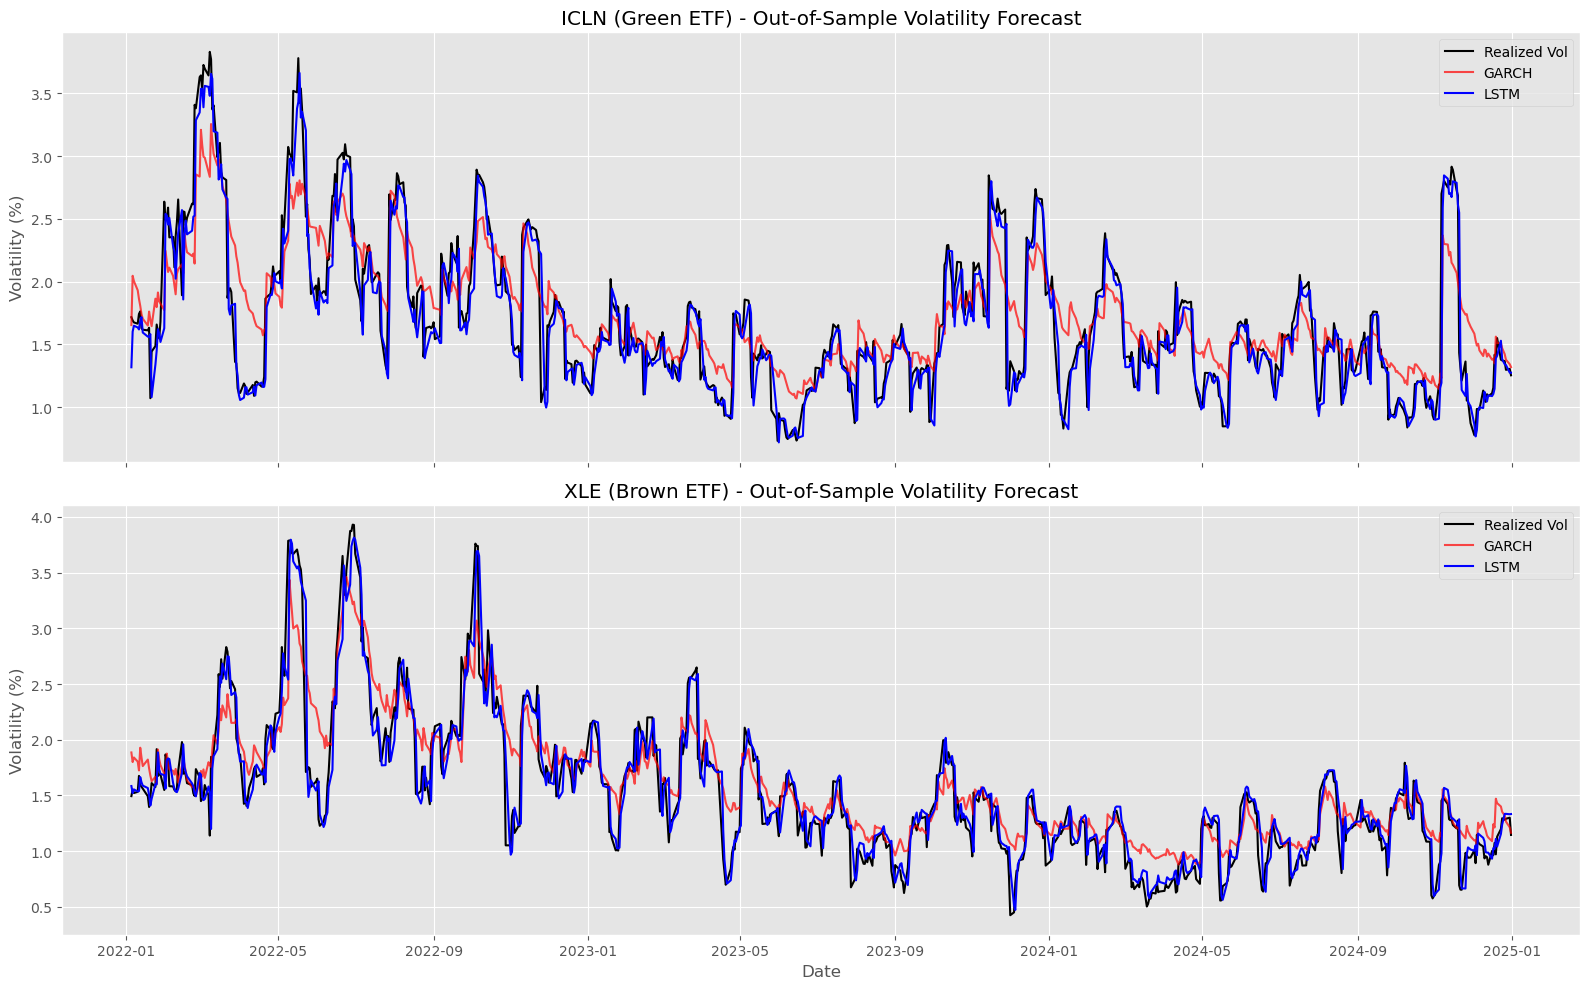

In [22]:
# CHUNK 12: MODEL PERFORMANCE SUMMARY AND VISUALIZATION (ICLN & XLE)

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load results
icln_res = pd.read_csv('/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/icln_volatility_forecast_lstm_vs_garch.csv', parse_dates=['date'], index_col='date')
xle_res  = pd.read_csv('/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/xle_volatility_forecast_lstm_vs_garch.csv', parse_dates=['date'], index_col='date')

# Compute metrics for ICLN
rmse_lstm_icln = mean_squared_error(icln_res['realized_vol'], icln_res['lstm_forecast'], squared=False)
mae_lstm_icln  = mean_absolute_error(icln_res['realized_vol'], icln_res['lstm_forecast'])
rmse_garch_icln = mean_squared_error(icln_res['realized_vol'], icln_res['garch_forecast'], squared=False)
mae_garch_icln  = mean_absolute_error(icln_res['realized_vol'], icln_res['garch_forecast'])

# Compute metrics for XLE
rmse_lstm_xle = mean_squared_error(xle_res['realized_vol'], xle_res['lstm_forecast'], squared=False)
mae_lstm_xle  = mean_absolute_error(xle_res['realized_vol'], xle_res['lstm_forecast'])
rmse_garch_xle = mean_squared_error(xle_res['realized_vol'], xle_res['garch_forecast'], squared=False)
mae_garch_xle  = mean_absolute_error(xle_res['realized_vol'], xle_res['garch_forecast'])

# Make summary table
summary = pd.DataFrame({
    'ETF': ['ICLN', 'ICLN', 'XLE', 'XLE'],
    'Model': ['LSTM', 'GARCH', 'LSTM', 'GARCH'],
    'RMSE': [rmse_lstm_icln, rmse_garch_icln, rmse_lstm_xle, rmse_garch_xle],
    'MAE': [mae_lstm_icln, mae_garch_icln, mae_lstm_xle, mae_garch_xle]
})
print("\nModel Out-of-Sample Error Metrics (Volatility):")
print(summary)

summary.to_csv('/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/volatility_model_performance_summary.csv', index=False)
print("\nSaved performance summary as volatility_model_performance_summary.csv")

# --- Visualize (panel plot for easy side-by-side comparison) ---
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

axes[0].plot(icln_res.index, icln_res['realized_vol'], label='Realized Vol', color='black')
axes[0].plot(icln_res.index, icln_res['garch_forecast'], label='GARCH', color='red', alpha=0.7)
axes[0].plot(icln_res.index, icln_res['lstm_forecast'], label='LSTM', color='blue')
axes[0].set_title('ICLN (Green ETF) - Out-of-Sample Volatility Forecast')
axes[0].set_ylabel('Volatility (%)')
axes[0].legend()

axes[1].plot(xle_res.index, xle_res['realized_vol'], label='Realized Vol', color='black')
axes[1].plot(xle_res.index, xle_res['garch_forecast'], label='GARCH', color='red', alpha=0.7)
axes[1].plot(xle_res.index, xle_res['lstm_forecast'], label='LSTM', color='blue')
axes[1].set_title('XLE (Brown ETF) - Out-of-Sample Volatility Forecast')
axes[1].set_ylabel('Volatility (%)')
axes[1].set_xlabel('Date')
axes[1].legend()

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# END OF CHUNK 12
# ------------------------------------------------------------


Cleaned columns: ['icln_icln', 'xle_xle', 'vix_vix', 'brent_bz_f', 'sp500_gspc', 'dgs10', 'carbon_eua', 'icln_icln_ret', 'xle_xle_ret', 'brent_bz_f_ret', 'carbon_eua_ret', 'sp500_gspc_ret', 'dgs10_diff', 'carbon_shock_resid', 'carbon_shock', 'icln_vol', 'xle_vol']

Detected columns:
icln_ret_col: icln_icln_ret
xle_ret_col: xle_xle_ret
icln_vol_col: icln_vol
xle_vol_col: xle_vol
carbon_shock_col: carbon_shock_resid
vix_col: vix_vix
brent_col: brent_bz_f
sp500_ret_col: None
dgs10_col: dgs10
dgs10_diff_col: dgs10_diff

Macro controls in feature matrix: ['vix_vix', 'brent_bz_f', 'dgs10']

Fitting Causal Forest for ICLN returns (N=3771 rows)...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed: 


ICLN Average Treatment Effect (ATE): 0.05430360405868068


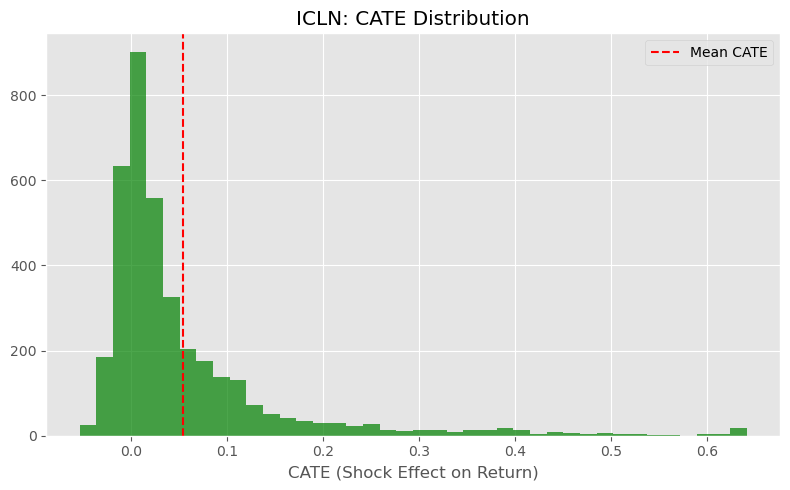

Saved CATEs for ICLN as icln_causal_forest_cates.csv

Fitting Causal Forest for XLE returns (N=3771 rows)...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed: 


XLE Average Treatment Effect (ATE): 0.10098595244808557


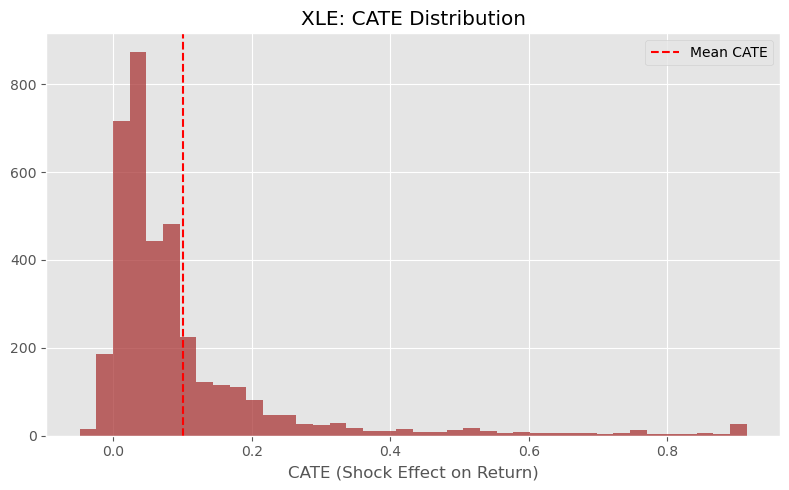

Saved CATEs for XLE as xle_causal_forest_cates.csv

Done.


In [23]:
import pandas as pd
import numpy as np
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import re

# Load data
df = pd.read_csv('/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/financial_data_returns_shocks_vol_2010_2024.csv', index_col=0, parse_dates=True)

def clean_col(col):
    s = re.sub(r'[^0-9a-zA-Z_]+', '_', col).strip('_')
    s = re.sub(r'_+', '_', s)
    return s.lower()

df.columns = [clean_col(col) for col in df.columns]
print("Cleaned columns:", list(df.columns))

def find_col(substring, columns):
    substring = substring.lower().strip('_')
    for col in columns:
        if substring in col.strip('_').lower():
            return col
    return None

# Key columns for both ETFs
icln_ret_col = find_col('icln_ret', df.columns)
xle_ret_col  = find_col('xle_ret', df.columns)
icln_vol_col = find_col('icln_vol', df.columns)
xle_vol_col  = find_col('xle_vol', df.columns)
carbon_shock_col = find_col('carbon_shock', df.columns)
vix_col = find_col('vix', df.columns)
brent_col = find_col('brent', df.columns)
sp500_ret_col = find_col('sp500_ret', df.columns)
dgs10_col = find_col('dgs10', df.columns)
dgs10_diff_col = find_col('dgs10_diff', df.columns)

# Print detected
print("\nDetected columns:")
for varname, val in [
    ("icln_ret_col", icln_ret_col), ("xle_ret_col", xle_ret_col),
    ("icln_vol_col", icln_vol_col), ("xle_vol_col", xle_vol_col),
    ("carbon_shock_col", carbon_shock_col),
    ("vix_col", vix_col), ("brent_col", brent_col),
    ("sp500_ret_col", sp500_ret_col), ("dgs10_col", dgs10_col), ("dgs10_diff_col", dgs10_diff_col)
]:
    print(f"{varname}: {val}")

# Helper: Build list of valid macro controls for feature matrix
def valid_controls(cols, df):
    controls = []
    for col in cols:
        if col and col in df.columns:
            ser = df[col]
            if pd.api.types.is_numeric_dtype(ser) and ser.notnull().sum() > 1 and ser.nunique(dropna=True) > 1:
                controls.append(col)
    return controls

macro_controls = valid_controls([vix_col, brent_col, sp500_ret_col, dgs10_col], df)
print("\nMacro controls in feature matrix:", macro_controls)

# For both ETFs: run causal forest only if all required columns are present
results = []
for label, ret_col, vol_col in [
    ('ICLN', icln_ret_col, icln_vol_col),
    ('XLE', xle_ret_col, xle_vol_col)
]:
    if ret_col and vol_col and carbon_shock_col:
        df_sub = df.dropna(subset=[ret_col, vol_col, carbon_shock_col] + macro_controls)
        Y = df_sub[ret_col].values
        T = df_sub[carbon_shock_col].values
        X = df_sub[[vol_col] + macro_controls].values
        print(f"\nFitting Causal Forest for {label} returns (N={len(df_sub)} rows)...")
        est = CausalForestDML(
            model_y=RandomForestRegressor(n_estimators=100, min_samples_leaf=10),
            model_t=RandomForestRegressor(n_estimators=100, min_samples_leaf=10),
            n_estimators=500,
            min_samples_leaf=10,
            verbose=1,
            random_state=42
        )
        est.fit(Y, T, X=X)
        ate = est.ate(X)
        cate = est.effect(X)
        print(f"\n{label} Average Treatment Effect (ATE): {ate}")
        # Save/plot CATEs
        plt.figure(figsize=(8,5))
        plt.hist(cate, bins=40, alpha=0.7, color=('green' if label == 'ICLN' else 'brown'))
        plt.axvline(np.mean(cate), color='red', linestyle='--', label='Mean CATE')
        plt.title(f'{label}: CATE Distribution')
        plt.xlabel('CATE (Shock Effect on Return)')
        plt.legend()
        plt.tight_layout()
        plt.show()
        # Save to CSV
        cate_df = pd.DataFrame({'date': df_sub.index, f'{label.lower()}_cate': cate}).set_index('date')
        cate_df.to_csv(f'/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/{label.lower()}_causal_forest_cates.csv')
        print(f"Saved CATEs for {label} as {label.lower()}_causal_forest_cates.csv")
        results.append((label, ate, np.mean(cate), np.std(cate)))
    else:
        print(f"Skipping {label}: Missing required columns.")

print("\nDone.")

# ------------------------------------------------------------
# END OF UPDATED CHUNK 13
# ------------------------------------------------------------



ICLN mean CATE: 0.05430
ICLN: t-stat = 33.10, p = 0.0000
ICLN bootstrapped 95% CI: 0.05117 to 0.05741
ICLN Placebo mean CATE: -0.00069, std = 0.03793


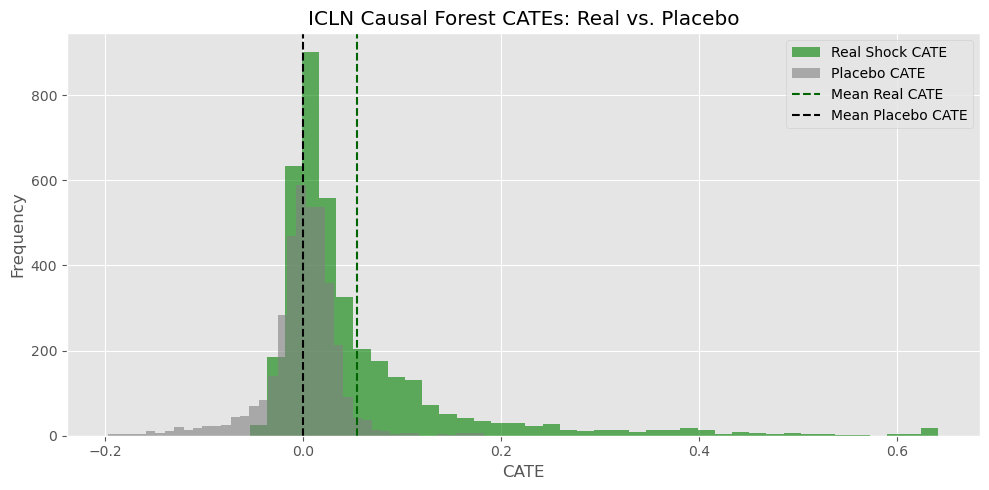


XLE mean CATE: 0.10099
XLE: t-stat = 41.59, p = 0.0000
XLE bootstrapped 95% CI: 0.09611 to 0.10563
XLE Placebo mean CATE: 0.00895, std = 0.02883


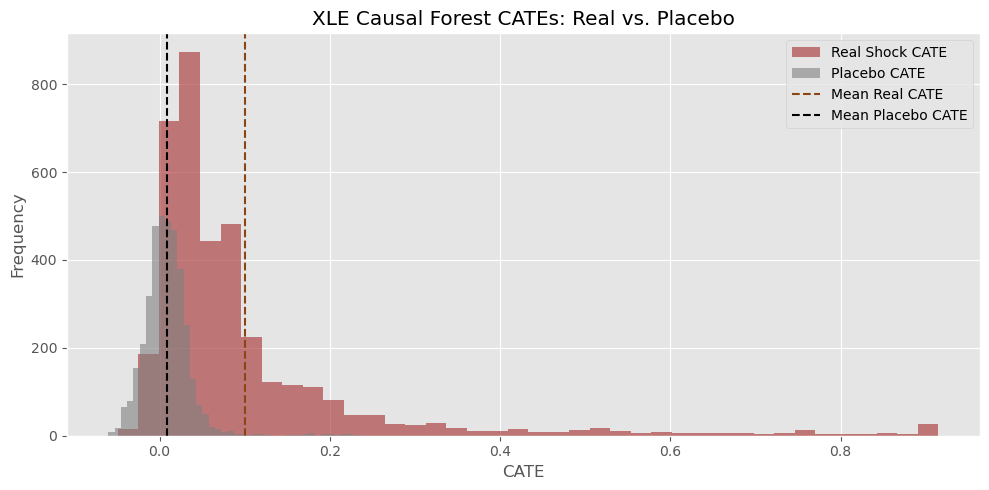


Saved robustness results as causal_forest_robustness_results.csv.


In [24]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_1samp
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import re

# Load data and CATEs
df = pd.read_csv('/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/financial_data_returns_shocks_vol_2010_2024.csv', index_col=0, parse_dates=True)
def clean_col(col):
    s = re.sub(r'[^0-9a-zA-Z_]+', '_', col).strip('_')
    s = re.sub(r'_+', '_', s)
    return s.lower()
df.columns = [clean_col(col) for col in df.columns]

def find_col(substring, columns):
    substring = substring.lower().strip('_')
    for col in columns:
        if substring in col.strip('_').lower():
            return col
    return None

# Helper for valid macro controls
def valid_controls(cols, df):
    controls = []
    for col in cols:
        if col and col in df.columns:
            ser = df[col]
            if pd.api.types.is_numeric_dtype(ser) and ser.notnull().sum() > 1 and ser.nunique(dropna=True) > 1:
                controls.append(col)
    return controls

vix_col = find_col('vix', df.columns)
brent_col = find_col('brent', df.columns)
sp500_ret_col = find_col('sp500_ret', df.columns)
dgs10_col = find_col('dgs10', df.columns)
dgs10_diff_col = find_col('dgs10_diff', df.columns)
macro_controls = valid_controls([vix_col, brent_col, sp500_ret_col, dgs10_col], df)

icln_ret_col = find_col('icln_ret', df.columns)
icln_vol_col = find_col('icln_vol', df.columns)
xle_ret_col = find_col('xle_ret', df.columns)
xle_vol_col = find_col('xle_vol', df.columns)
carbon_shock_col = find_col('carbon_shock', df.columns)

def bootstrap_ci(series, n_boot=1000, ci=95):
    means = []
    for _ in range(n_boot):
        means.append(series.sample(frac=1, replace=True).mean())
    lower = np.percentile(means, (100-ci)/2)
    upper = np.percentile(means, 100-(100-ci)/2)
    return lower, upper

results_df = []

for label, ret_col, vol_col in [
    ('ICLN', icln_ret_col, icln_vol_col),
    ('XLE', xle_ret_col, xle_vol_col)
]:
    try:
        cate_path = f'/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/{label.lower()}_causal_forest_cates.csv'
        cate = pd.read_csv(cate_path, parse_dates=['date'], index_col='date')
        cate_col = cate.columns[0]
        print(f"\n{label} mean CATE: {cate[cate_col].mean():.5f}")

        t_stat, p_val = ttest_1samp(cate[cate_col], 0)
        print(f"{label}: t-stat = {t_stat:.2f}, p = {p_val:.4f}")

        ci = bootstrap_ci(cate[cate_col])
        print(f"{label} bootstrapped 95% CI: {ci[0]:.5f} to {ci[1]:.5f}")

        # Placebo test (shuffle shocks)
        df_sub = df.dropna(subset=[ret_col, vol_col, carbon_shock_col] + macro_controls)
        Y = df_sub[ret_col].values
        T_real = df_sub[carbon_shock_col].values
        X = df_sub[[vol_col] + macro_controls].values
        np.random.seed(42)
        T_fake = np.random.permutation(T_real)
        est_fake = CausalForestDML(
            model_y=RandomForestRegressor(n_estimators=100, min_samples_leaf=10),
            model_t=RandomForestRegressor(n_estimators=100, min_samples_leaf=10),
            n_estimators=500,
            min_samples_leaf=10,
            verbose=0,
            random_state=42
        )
        est_fake.fit(Y, T_fake, X=X)
        fake_cate = est_fake.effect(X)
        print(f"{label} Placebo mean CATE: {np.mean(fake_cate):.5f}, std = {np.std(fake_cate):.5f}")

        # Histogram: Real vs. Placebo CATEs
        plt.figure(figsize=(10,5))
        plt.hist(cate[cate_col], bins=40, alpha=0.6, label='Real Shock CATE', color='green' if label == 'ICLN' else 'brown')
        plt.hist(fake_cate, bins=40, alpha=0.6, label='Placebo CATE', color='gray')
        plt.axvline(np.mean(cate[cate_col]), color='darkgreen' if label == 'ICLN' else 'saddlebrown', linestyle='--', label='Mean Real CATE')
        plt.axvline(np.mean(fake_cate), color='black', linestyle='--', label='Mean Placebo CATE')
        plt.title(f'{label} Causal Forest CATEs: Real vs. Placebo')
        plt.xlabel('CATE')
        plt.ylabel('Frequency')
        plt.legend()
        plt.tight_layout()
        plt.show()

        results_df.append({
            'ETF': label,
            'Mean_CATE': cate[cate_col].mean(),
            'T_stat': t_stat,
            'P_value': p_val,
            'Bootstrapped_CI_low': ci[0],
            'Bootstrapped_CI_high': ci[1],
            'Placebo_Mean_CATE': np.mean(fake_cate),
            'Placebo_Std_CATE': np.std(fake_cate)
        })
    except Exception as e:
        print(f"Could not compute robustness for {label}: {e}")

summary = pd.DataFrame(results_df)
summary.to_csv('/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/causal_forest_robustness_results.csv', index=False)
print("\nSaved robustness results as causal_forest_robustness_results.csv.")

# ------------------------------------------------------------
# END OF UPDATED CHUNK 14
# ------------------------------------------------------------


Detected columns for visualization:
icln_ret_col: icln_icln_ret
xle_ret_col: xle_xle_ret
carbon_col: carbon_eua
icln_vol_col: icln_vol
xle_vol_col: xle_vol
carbon_shock_col: carbon_shock_resid

Number of carbon shock days: 0
Sample shock dates: DatetimeIndex([], dtype='datetime64[ns]', name='date', freq=None)
ICLN returns NaN at shock dates: 0 out of 0
ICLN volatility NaN at shock dates: 0 out of 0


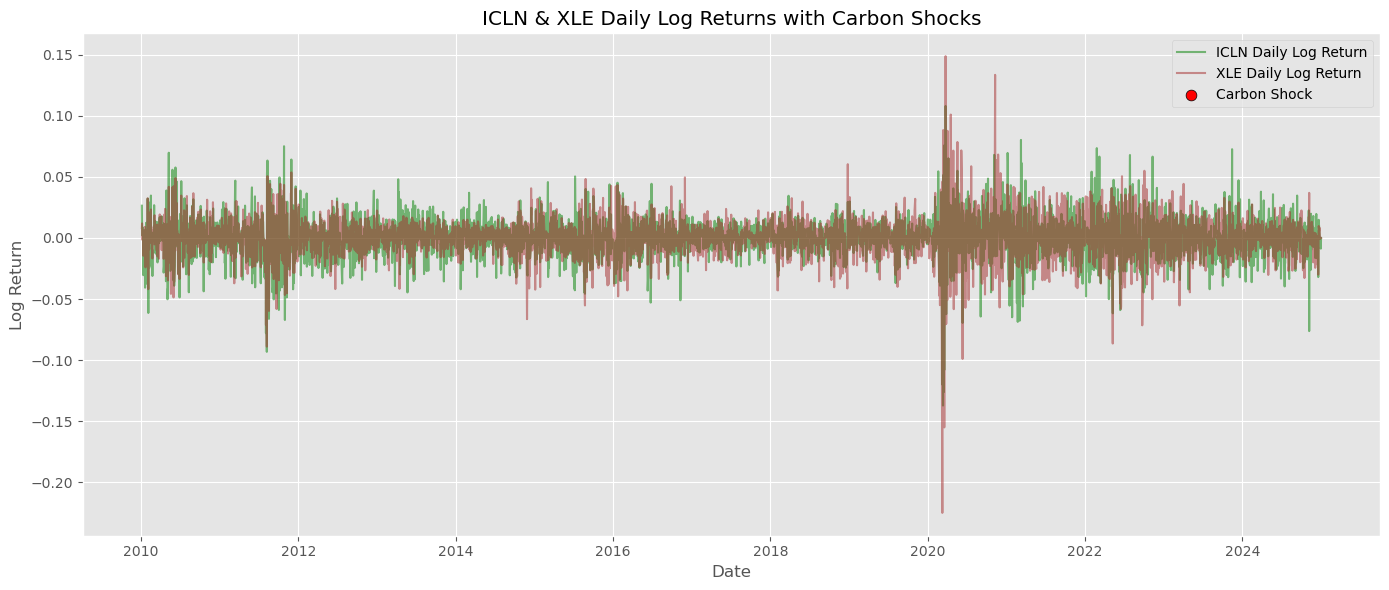

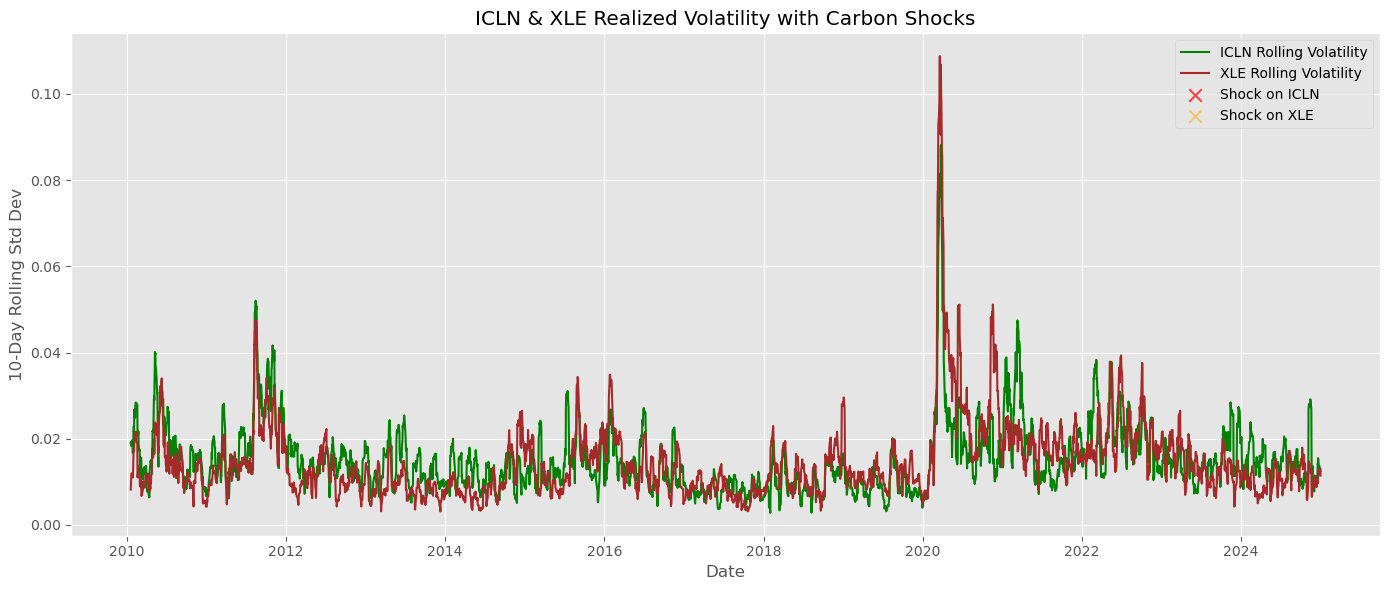

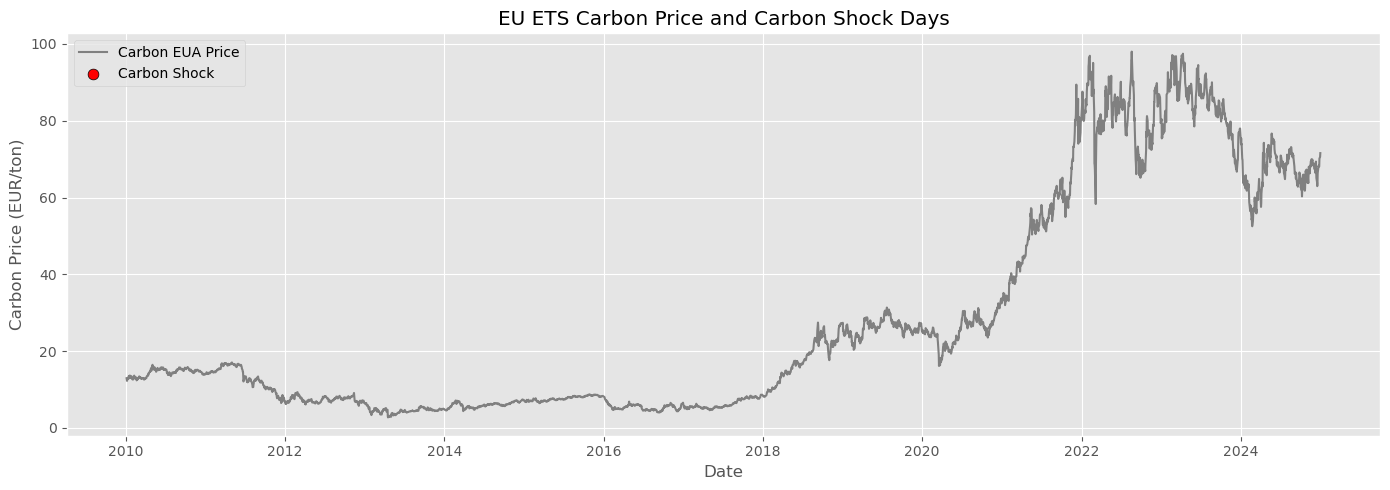


Saved carbon shock event dates as carbon_shock_event_dates.csv

All figures saved. Check your PNGs and CSV output!


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# 1. Load data
csv_path = '/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/financial_data_garch_2010_2024.csv'
df = pd.read_csv(csv_path, index_col=0, parse_dates=True)

def clean_col(col):
    s = re.sub(r'[^0-9a-zA-Z_]+', '_', col).strip('_')
    s = re.sub(r'_+', '_', s)
    return s.lower()

df.columns = [clean_col(col) for col in df.columns]

def find_col(substring, columns):
    substring = substring.lower().strip('_')
    for col in columns:
        if substring in col.strip('_').lower():
            return col
    return None

# Detect columns robustly
icln_ret_col = find_col('icln_ret', df.columns)
xle_ret_col = find_col('xle_ret', df.columns)
carbon_col = find_col('carbon_eua', df.columns)
icln_vol_col = find_col('icln_vol', df.columns)
xle_vol_col = find_col('xle_vol', df.columns)
carbon_shock_col = find_col('carbon_shock', df.columns)

# --- If only the residual is present, create the shock flag now ---
if not carbon_shock_col:
    resid_col = find_col('carbon_shock_resid', df.columns)
    if resid_col:
        resid = df[resid_col]
        threshold = 1.5 * np.nanstd(resid)
        df['carbon_shock'] = (resid.abs() > threshold).astype(int)
        carbon_shock_col = 'carbon_shock'
        print(f"Auto-created carbon_shock column: {df['carbon_shock'].sum()} shocks (threshold={threshold:.4f})")
        # Save for future steps
        df.to_csv(csv_path)
    else:
        print("No carbon shock residual or flag found; cannot plot shocks.")
        carbon_shock_col = None

print("Detected columns for visualization:")
for name, val in [
    ('icln_ret_col', icln_ret_col),
    ('xle_ret_col', xle_ret_col),
    ('carbon_col', carbon_col),
    ('icln_vol_col', icln_vol_col),
    ('xle_vol_col', xle_vol_col),
    ('carbon_shock_col', carbon_shock_col)
]:
    print(f"{name}: {val}")

# --- Calculate shock_dates and debug print ---
if carbon_shock_col:
    shock_dates = df.index[df[carbon_shock_col] == 1]
    print(f"\nNumber of carbon shock days: {len(shock_dates)}")
    print("Sample shock dates:", shock_dates[:10])
    if icln_ret_col:
        nan_count = df.loc[shock_dates, icln_ret_col].isnull().sum()
        print(f"ICLN returns NaN at shock dates: {nan_count} out of {len(shock_dates)}")
    if icln_vol_col:
        nan_vol_count = df.loc[shock_dates, icln_vol_col].isnull().sum()
        print(f"ICLN volatility NaN at shock dates: {nan_vol_count} out of {len(shock_dates)}")
else:
    shock_dates = []

# 2. Annotated Event Study Plot (Returns)
plt.figure(figsize=(14,6))
if icln_ret_col:
    plt.plot(df.index, df[icln_ret_col], label='ICLN Daily Log Return', color='green', alpha=0.5)
if xle_ret_col:
    plt.plot(df.index, df[xle_ret_col], label='XLE Daily Log Return', color='brown', alpha=0.5)
if carbon_shock_col and icln_ret_col:
    plt.scatter(shock_dates, df.loc[shock_dates, icln_ret_col], 
                color='red', label='Carbon Shock', zorder=10, s=60, edgecolor='black')
plt.title('ICLN & XLE Daily Log Returns with Carbon Shocks')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.tight_layout()
plt.savefig('/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/event_study_returns_shocks.png')
plt.show()

# 3. Annotated Volatility Plot
plt.figure(figsize=(14,6))
if icln_vol_col:
    plt.plot(df.index, df[icln_vol_col], label='ICLN Rolling Volatility', color='green')
if xle_vol_col:
    plt.plot(df.index, df[xle_vol_col], label='XLE Rolling Volatility', color='brown')
if carbon_shock_col and icln_vol_col:
    plt.scatter(shock_dates, df.loc[shock_dates, icln_vol_col], 
                color='red', marker='x', label='Shock on ICLN', alpha=0.7, s=80, zorder=10)
if carbon_shock_col and xle_vol_col:
    plt.scatter(shock_dates, df.loc[shock_dates, xle_vol_col], 
                color='orange', marker='x', label='Shock on XLE', alpha=0.5, s=80, zorder=10)
plt.title('ICLN & XLE Realized Volatility with Carbon Shocks')
plt.xlabel('Date')
plt.ylabel('10-Day Rolling Std Dev')
plt.legend()
plt.tight_layout()
plt.savefig('/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/event_study_volatility_shocks.png')
plt.show()

# 4. Carbon Price Plot with Events
plt.figure(figsize=(14,5))
if carbon_col:
    plt.plot(df.index, df[carbon_col], label='Carbon EUA Price', color='gray')
    if carbon_shock_col:
        plt.scatter(shock_dates, df.loc[shock_dates, carbon_col], color='red', label='Carbon Shock', s=60, edgecolor='black', zorder=10)
plt.title('EU ETS Carbon Price and Carbon Shock Days')
plt.xlabel('Date')
plt.ylabel('Carbon Price (EUR/ton)')
plt.legend()
plt.tight_layout()
plt.savefig('/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/carbon_price_shocks.png')
plt.show()

# 5. Save list of carbon shock dates for appendix
if carbon_shock_col:
    shock_list = pd.DataFrame({'date': shock_dates})
    shock_list.to_csv('/Users/aditya/Desktop/MSQE PROJECT/Project_Data_14Yr/carbon_shock_event_dates.csv', index=False)
    print("\nSaved carbon shock event dates as carbon_shock_event_dates.csv")

print("\nAll figures saved. Check your PNGs and CSV output!")

# ------------------------------------------------------------
# END OF CHUNK 15 (FINAL VERSION)
# ------------------------------------------------------------
